In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
#data set
url = "https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download"
output = "data.zip"
gdown.download(url, output)
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download
From (redirected): https://drive.google.com/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download&confirm=t&uuid=206176e1-aeb1-4874-b140-326fb5bf8f44
To: /content/data.zip
100%|██████████| 173M/173M [00:06<00:00, 26.7MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data/jammed_channel/images/2_104.png  
  inflating: data/jammed_channel/images/2_105.png  
  inflating: data/jammed_channel/images/2_106.png  
  inflating: data/jammed_channel/images/2_107.png  
  inflating: data/jammed_channel/images/2_108.png  
  inflating: data/jammed_channel/images/2_109.png  
  inflating: data/jammed_channel/images/2_110.png  
  inflating: data/jammed_channel/images/2_111.png  
  inflating: data/jammed_channel/images/2_112.png  
  inflating: data/jammed_channel/images/2_113.png  
  inflating: data/jammed_channel/images/2_114.png  
  inflating: data/jammed_channel/images/2_115.png  
  inflating: data/jammed_channel/images/2_116.png  
  inflating: data/jammed_channel/images/2_117.png  
  inflating: data/jammed_channel/images/2_118.png  
  inflating: data/jammed_channel/images/2_119.png  
  inflating: data/jammed_channel/images/2_120.png  
  inflating: data/jammed_channel/images/2_121.png  
  inflating: d

In [3]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data")):
    print(folder)
    for im in tqdm(os.listdir("data/"+folder+"/images/")):
        if folder == "clean":
            clean.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_anomalies.append(1)
        else:
          test.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_test.append(mapping[int(im[0])])
    ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                   

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:31<01:34, 31.41s/it]

jammed_channel



 50%|█████     | 2/4 [00:34<00:29, 14.63s/it]

test



 75%|███████▌  | 3/4 [00:39<00:10, 10.32s/it]

clean_validation



100%|██████████| 4/4 [00:42<00:00, 10.63s/it]


In [4]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [5]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



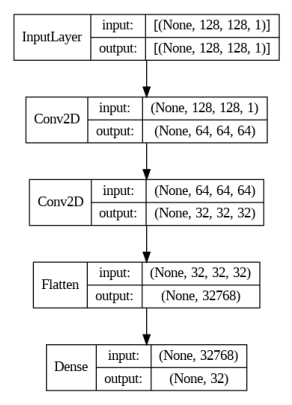

Summary of the decoder:



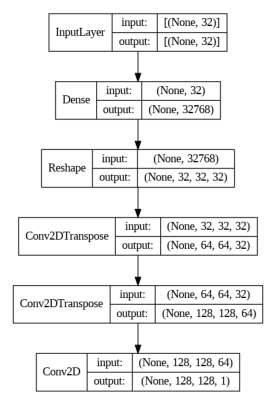

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [7]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 12s 46ms/step - loss: 0.0428 - val_loss: 0.0358
Epoch 2/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0352 - val_loss: 0.0354
Epoch 3/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0349 - val_loss: 0.0351
Epoch 4/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0337 - val_loss: 0.0314
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0290 - val_loss: 0.0283
Epoch 6/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0279 - val_loss: 0.0280
Epoch 7/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0277 - val_loss: 0.0279
Epoch 8/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 9/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 10/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0275 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

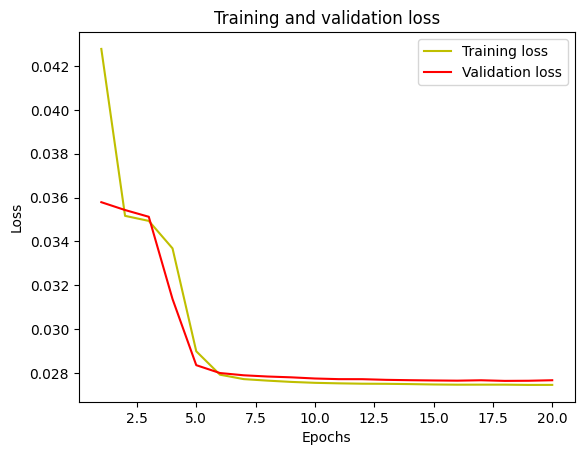

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 0s 21ms/step


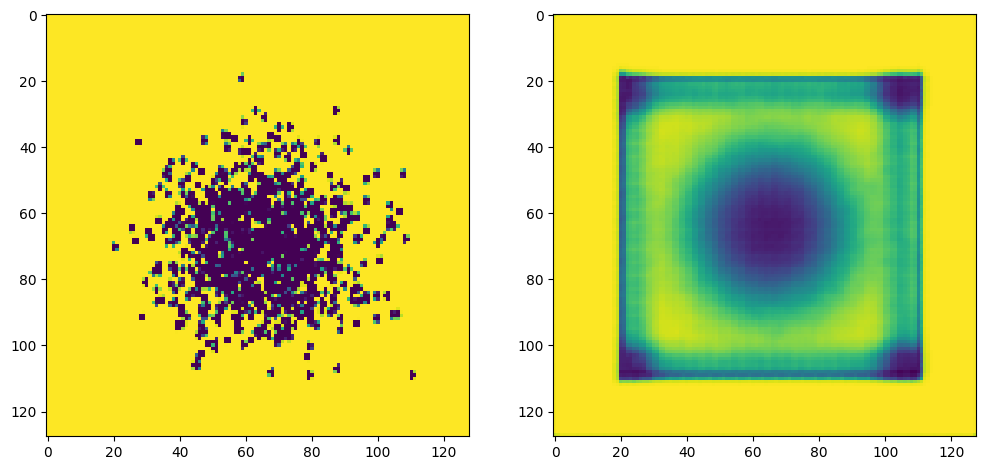

In [17]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [18]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 0s 19ms/step - loss: 0.0489
Validation error 0.02766193076968193
Anomaly error 0.048866938799619675
The reconstruction error of the jammed channel is  1.7665772937722368  more than the clean channel


In [12]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [13]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 116ms/step - loss: 0.0259


  0%|          | 1/600 [00:00<02:04,  4.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0278


  0%|          | 3/600 [00:00<01:04,  9.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0252


  1%|          | 5/600 [00:00<01:04,  9.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0267


  1%|          | 7/600 [00:00<00:57, 10.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0277


  2%|▏         | 9/600 [00:00<00:55, 10.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0255


  2%|▏         | 11/600 [00:01<00:56, 10.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0257


  2%|▏         | 13/600 [00:01<00:57, 10.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0296


  2%|▎         | 15/600 [00:01<01:01,  9.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0244


  3%|▎         | 17/600 [00:01<00:58,  9.92it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0283


  3%|▎         | 19/600 [00:01<00:58,  9.97it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0283


  4%|▎         | 21/600 [00:02<00:57, 10.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0280


  4%|▍         | 23/600 [00:02<00:57, 10.03it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0294


  4%|▍         | 25/600 [00:02<00:56, 10.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0273


  4%|▍         | 27/600 [00:02<00:55, 10.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0248


  5%|▍         | 29/600 [00:02<00:51, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0250


  5%|▌         | 31/600 [00:03<00:48, 11.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


  6%|▌         | 33/600 [00:03<00:44, 12.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


  6%|▌         | 35/600 [00:03<00:42, 13.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0282


  6%|▌         | 37/600 [00:03<01:02,  8.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0319


  6%|▋         | 39/600 [00:03<00:55, 10.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


  7%|▋         | 41/600 [00:03<00:50, 11.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0264


  7%|▋         | 43/600 [00:04<00:46, 12.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0251


  8%|▊         | 45/600 [00:04<00:43, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0254


  8%|▊         | 47/600 [00:04<00:43, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0301


  8%|▊         | 49/600 [00:04<00:41, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


  8%|▊         | 51/600 [00:04<00:40, 13.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


  9%|▉         | 53/600 [00:04<00:40, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0263


  9%|▉         | 55/600 [00:04<00:39, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0248


 10%|▉         | 57/600 [00:05<00:39, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 10%|▉         | 59/600 [00:05<00:38, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 10%|█         | 61/600 [00:05<00:39, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 10%|█         | 63/600 [00:05<00:39, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0229


 11%|█         | 65/600 [00:05<00:39, 13.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0259


 11%|█         | 67/600 [00:05<00:45, 11.76it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0284


 12%|█▏        | 69/600 [00:06<00:50, 10.42it/s]

1/1 [==============================] - 0s 101ms/step - loss: 0.0278


 12%|█▏        | 71/600 [00:06<01:03,  8.33it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0270


 12%|█▏        | 72/600 [00:06<01:04,  8.20it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0256


 12%|█▏        | 73/600 [00:06<01:02,  8.44it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0257


 12%|█▏        | 74/600 [00:06<01:00,  8.71it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0269


 12%|█▎        | 75/600 [00:06<01:02,  8.37it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0293


 13%|█▎        | 76/600 [00:07<01:06,  7.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0278


 13%|█▎        | 77/600 [00:07<01:04,  8.06it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0296


 13%|█▎        | 78/600 [00:07<01:03,  8.20it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0264


 13%|█▎        | 79/600 [00:07<01:02,  8.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0224


 13%|█▎        | 80/600 [00:07<01:02,  8.31it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0265


 14%|█▎        | 81/600 [00:07<01:06,  7.75it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0270


 14%|█▎        | 82/600 [00:07<01:09,  7.40it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0267


 14%|█▍        | 83/600 [00:08<01:09,  7.39it/s]

1/1 [==============================] - 0s 81ms/step - loss: 0.0244


 14%|█▍        | 84/600 [00:08<01:24,  6.08it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0287


 14%|█▍        | 85/600 [00:08<01:26,  5.97it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0290


 14%|█▍        | 86/600 [00:08<01:20,  6.35it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0270


 14%|█▍        | 87/600 [00:08<01:17,  6.58it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0276


 15%|█▍        | 88/600 [00:08<01:12,  7.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0282


 15%|█▍        | 89/600 [00:08<01:07,  7.53it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0292


 15%|█▌        | 90/600 [00:09<01:08,  7.45it/s]

1/1 [==============================] - 0s 109ms/step - loss: 0.0282


 15%|█▌        | 91/600 [00:09<01:14,  6.83it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0259


 15%|█▌        | 92/600 [00:09<01:09,  7.31it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0300


 16%|█▌        | 93/600 [00:09<01:05,  7.79it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0231


 16%|█▌        | 94/600 [00:09<01:02,  8.10it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0252


 16%|█▌        | 95/600 [00:09<01:03,  7.98it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0241


 16%|█▌        | 97/600 [00:09<00:58,  8.66it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0279


 16%|█▋        | 98/600 [00:10<01:01,  8.10it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0288


 16%|█▋        | 99/600 [00:10<01:00,  8.25it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0276


 17%|█▋        | 100/600 [00:10<00:59,  8.43it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0279


 17%|█▋        | 101/600 [00:10<01:05,  7.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0266


 17%|█▋        | 102/600 [00:10<01:03,  7.84it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0312


 17%|█▋        | 103/600 [00:10<01:01,  8.11it/s]

1/1 [==============================] - 0s 67ms/step - loss: 0.0278


 18%|█▊        | 105/600 [00:10<00:59,  8.32it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0277


 18%|█▊        | 106/600 [00:11<00:57,  8.54it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0280


 18%|█▊        | 107/600 [00:11<00:56,  8.71it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0311


 18%|█▊        | 108/600 [00:11<01:01,  7.94it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0279


 18%|█▊        | 109/600 [00:11<00:59,  8.26it/s]

1/1 [==============================] - 0s 92ms/step - loss: 0.0278


 18%|█▊        | 110/600 [00:11<01:15,  6.51it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0262


 18%|█▊        | 111/600 [00:11<01:14,  6.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0281


 19%|█▊        | 112/600 [00:11<01:12,  6.76it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0303


 19%|█▉        | 113/600 [00:12<01:08,  7.13it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0304


 19%|█▉        | 114/600 [00:12<01:10,  6.91it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0276


 19%|█▉        | 115/600 [00:12<01:24,  5.77it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0293


 19%|█▉        | 116/600 [00:12<01:16,  6.35it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0275


 20%|█▉        | 117/600 [00:12<01:09,  6.91it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0268


 20%|█▉        | 118/600 [00:12<01:06,  7.24it/s]

1/1 [==============================] - 0s 83ms/step - loss: 0.0318


 20%|█▉        | 119/600 [00:13<01:26,  5.57it/s]

1/1 [==============================] - 0s 85ms/step - loss: 0.0287


 20%|██        | 120/600 [00:13<01:30,  5.28it/s]

1/1 [==============================] - 0s 123ms/step - loss: 0.0295


 20%|██        | 121/600 [00:13<01:44,  4.57it/s]

1/1 [==============================] - 0s 114ms/step - loss: 0.0263


 20%|██        | 122/600 [00:13<01:46,  4.47it/s]

1/1 [==============================] - 0s 89ms/step - loss: 0.0280


 20%|██        | 123/600 [00:14<01:49,  4.37it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0278


 21%|██        | 124/600 [00:14<01:39,  4.79it/s]

1/1 [==============================] - 0s 112ms/step - loss: 0.0288


 21%|██        | 125/600 [00:14<01:51,  4.27it/s]

1/1 [==============================] - 0s 100ms/step - loss: 0.0280


 21%|██        | 126/600 [00:14<01:52,  4.23it/s]

1/1 [==============================] - 0s 133ms/step - loss: 0.0314


 21%|██        | 127/600 [00:15<02:00,  3.92it/s]

1/1 [==============================] - 0s 166ms/step - loss: 0.0291


 21%|██▏       | 128/600 [00:15<02:18,  3.40it/s]

1/1 [==============================] - 0s 68ms/step - loss: 0.0285


 22%|██▏       | 129/600 [00:15<02:17,  3.44it/s]

1/1 [==============================] - 0s 73ms/step - loss: 0.0253


 22%|██▏       | 130/600 [00:15<02:07,  3.67it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0260


 22%|██▏       | 131/600 [00:16<01:49,  4.28it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0235


 22%|██▏       | 132/600 [00:16<01:37,  4.79it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0270


 22%|██▏       | 133/600 [00:16<01:22,  5.65it/s]

1/1 [==============================] - 0s 75ms/step - loss: 0.0320


 22%|██▏       | 134/600 [00:16<01:28,  5.25it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0265


 22%|██▎       | 135/600 [00:16<01:20,  5.80it/s]

1/1 [==============================] - 0s 66ms/step - loss: 0.0308


 23%|██▎       | 136/600 [00:16<01:27,  5.31it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0271


 23%|██▎       | 137/600 [00:17<01:15,  6.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0273


 23%|██▎       | 138/600 [00:17<01:06,  6.90it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0290


 23%|██▎       | 139/600 [00:17<01:09,  6.62it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0294


 23%|██▎       | 140/600 [00:17<01:15,  6.10it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0273


 24%|██▎       | 141/600 [00:17<01:21,  5.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0289


 24%|██▎       | 142/600 [00:17<01:12,  6.30it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0248


 24%|██▍       | 143/600 [00:17<01:15,  6.06it/s]

1/1 [==============================] - 0s 97ms/step - loss: 0.0273


 24%|██▍       | 144/600 [00:18<01:17,  5.86it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0266


 24%|██▍       | 145/600 [00:18<01:12,  6.24it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0285


 24%|██▍       | 146/600 [00:18<01:08,  6.66it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0289


 24%|██▍       | 147/600 [00:18<01:04,  7.01it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0280


 25%|██▍       | 148/600 [00:18<01:05,  6.87it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0281


 25%|██▍       | 149/600 [00:18<01:02,  7.22it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0293


 25%|██▌       | 150/600 [00:18<00:58,  7.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0266


 25%|██▌       | 151/600 [00:19<00:59,  7.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 26%|██▌       | 153/600 [00:19<00:46,  9.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 26%|██▌       | 155/600 [00:19<00:40, 11.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0263


 26%|██▌       | 157/600 [00:19<00:36, 12.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0301


 26%|██▋       | 159/600 [00:19<00:35, 12.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 27%|██▋       | 161/600 [00:19<00:34, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 27%|██▋       | 163/600 [00:19<00:33, 12.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 28%|██▊       | 165/600 [00:20<00:33, 13.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0284


 28%|██▊       | 167/600 [00:20<00:32, 13.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 28%|██▊       | 169/600 [00:20<00:33, 13.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0232


 28%|██▊       | 171/600 [00:20<00:31, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0279


 29%|██▉       | 173/600 [00:20<00:30, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 29%|██▉       | 175/600 [00:20<00:30, 14.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0259


 30%|██▉       | 177/600 [00:20<00:31, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0238


 30%|██▉       | 179/600 [00:21<00:30, 13.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0250


 30%|███       | 181/600 [00:21<00:30, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0277


 30%|███       | 183/600 [00:21<00:30, 13.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 31%|███       | 185/600 [00:21<00:30, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 31%|███       | 187/600 [00:21<00:29, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 32%|███▏      | 189/600 [00:21<00:30, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 32%|███▏      | 191/600 [00:21<00:29, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0290


 32%|███▏      | 193/600 [00:22<00:29, 13.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 32%|███▎      | 195/600 [00:22<00:29, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0258


 33%|███▎      | 197/600 [00:22<00:28, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 33%|███▎      | 199/600 [00:22<00:27, 14.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 34%|███▎      | 201/600 [00:22<00:27, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0251


 34%|███▍      | 203/600 [00:22<00:27, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 34%|███▍      | 205/600 [00:22<00:26, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 34%|███▍      | 207/600 [00:23<00:26, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


 35%|███▍      | 209/600 [00:23<00:27, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 35%|███▌      | 211/600 [00:23<00:27, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 36%|███▌      | 213/600 [00:23<00:26, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0231


 36%|███▌      | 215/600 [00:23<00:26, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 36%|███▌      | 217/600 [00:23<00:26, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 36%|███▋      | 219/600 [00:23<00:26, 14.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 37%|███▋      | 221/600 [00:24<00:26, 14.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0297


 37%|███▋      | 223/600 [00:24<00:26, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 38%|███▊      | 225/600 [00:24<00:26, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 38%|███▊      | 227/600 [00:24<00:26, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 38%|███▊      | 229/600 [00:24<00:25, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 38%|███▊      | 231/600 [00:24<00:25, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 39%|███▉      | 233/600 [00:24<00:25, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 39%|███▉      | 235/600 [00:25<00:25, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0231


 40%|███▉      | 237/600 [00:25<00:25, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 40%|███▉      | 239/600 [00:25<00:25, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 40%|████      | 241/600 [00:25<00:25, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 40%|████      | 243/600 [00:25<00:24, 14.52it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0264


 41%|████      | 245/600 [00:25<00:25, 13.73it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0272


 41%|████      | 247/600 [00:25<00:29, 12.11it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0272


 42%|████▏     | 249/600 [00:26<00:31, 11.19it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0266


 42%|████▏     | 251/600 [00:26<00:31, 10.99it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0307


 42%|████▏     | 253/600 [00:26<00:31, 11.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0293


 42%|████▎     | 255/600 [00:26<00:31, 10.94it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0268


 43%|████▎     | 257/600 [00:26<00:32, 10.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0224


 43%|████▎     | 259/600 [00:27<00:31, 10.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0297


 44%|████▎     | 261/600 [00:27<00:30, 10.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0245


 44%|████▍     | 263/600 [00:27<00:31, 10.86it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0227


 44%|████▍     | 265/600 [00:27<00:31, 10.60it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0292


 44%|████▍     | 267/600 [00:27<00:31, 10.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0269


 45%|████▍     | 269/600 [00:28<00:31, 10.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 45%|████▌     | 271/600 [00:28<00:31, 10.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 46%|████▌     | 273/600 [00:28<00:28, 11.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0506


 46%|████▌     | 275/600 [00:28<00:26, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 46%|████▌     | 277/600 [00:28<00:25, 12.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 46%|████▋     | 279/600 [00:28<00:23, 13.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0245


 47%|████▋     | 281/600 [00:28<00:23, 13.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0236


 47%|████▋     | 283/600 [00:29<00:23, 13.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0288


 48%|████▊     | 285/600 [00:29<00:22, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 48%|████▊     | 287/600 [00:29<00:22, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0225


 48%|████▊     | 289/600 [00:29<00:22, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0274


 48%|████▊     | 291/600 [00:29<00:22, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 49%|████▉     | 293/600 [00:29<00:21, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0250


 49%|████▉     | 295/600 [00:29<00:22, 13.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0264


 50%|████▉     | 297/600 [00:30<00:21, 13.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0238


 50%|████▉     | 299/600 [00:30<00:21, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0295


 50%|█████     | 301/600 [00:30<00:21, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0244


 50%|█████     | 303/600 [00:30<00:20, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 51%|█████     | 305/600 [00:30<00:21, 13.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0265


 51%|█████     | 307/600 [00:30<00:20, 14.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 52%|█████▏    | 309/600 [00:30<00:20, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 52%|█████▏    | 311/600 [00:31<00:20, 14.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 52%|█████▏    | 313/600 [00:31<00:19, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0228


 52%|█████▎    | 315/600 [00:31<00:19, 14.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 53%|█████▎    | 317/600 [00:31<00:19, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 53%|█████▎    | 319/600 [00:31<00:18, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 54%|█████▎    | 321/600 [00:31<00:19, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 54%|█████▍    | 323/600 [00:31<00:18, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 54%|█████▍    | 325/600 [00:32<00:18, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 55%|█████▍    | 327/600 [00:32<00:18, 14.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 55%|█████▍    | 329/600 [00:32<00:19, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0221


 55%|█████▌    | 331/600 [00:32<00:19, 13.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 56%|█████▌    | 333/600 [00:32<00:18, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 56%|█████▌    | 335/600 [00:32<00:18, 14.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0319


 56%|█████▌    | 337/600 [00:32<00:18, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 56%|█████▋    | 339/600 [00:33<00:19, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0316


 57%|█████▋    | 341/600 [00:33<00:18, 13.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 57%|█████▋    | 343/600 [00:33<00:18, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 57%|█████▊    | 345/600 [00:33<00:18, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0261


 58%|█████▊    | 347/600 [00:33<00:18, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 58%|█████▊    | 349/600 [00:33<00:18, 13.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 58%|█████▊    | 351/600 [00:33<00:17, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 59%|█████▉    | 353/600 [00:34<00:17, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0267


 59%|█████▉    | 355/600 [00:34<00:17, 13.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0296


 60%|█████▉    | 357/600 [00:34<00:17, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 60%|█████▉    | 359/600 [00:34<00:17, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 60%|██████    | 361/600 [00:34<00:17, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0268


 60%|██████    | 363/600 [00:34<00:17, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 61%|██████    | 365/600 [00:34<00:17, 13.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 61%|██████    | 367/600 [00:35<00:17, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0290


 62%|██████▏   | 369/600 [00:35<00:17, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 62%|██████▏   | 371/600 [00:35<00:16, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0306


 62%|██████▏   | 373/600 [00:35<00:16, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0468


 62%|██████▎   | 375/600 [00:35<00:16, 13.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0276


 63%|██████▎   | 377/600 [00:35<00:16, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0220


 63%|██████▎   | 379/600 [00:35<00:16, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 64%|██████▎   | 381/600 [00:36<00:15, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 64%|██████▍   | 383/600 [00:36<00:15, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 64%|██████▍   | 385/600 [00:36<00:15, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 64%|██████▍   | 387/600 [00:36<00:15, 13.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 65%|██████▍   | 389/600 [00:36<00:14, 14.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0284


 65%|██████▌   | 391/600 [00:36<00:15, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0252


 66%|██████▌   | 393/600 [00:36<00:15, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0294


 66%|██████▌   | 395/600 [00:37<00:15, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0282


 66%|██████▌   | 397/600 [00:37<00:14, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 66%|██████▋   | 399/600 [00:37<00:14, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 67%|██████▋   | 401/600 [00:37<00:14, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 67%|██████▋   | 403/600 [00:37<00:14, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0466


 68%|██████▊   | 405/600 [00:37<00:14, 13.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 68%|██████▊   | 407/600 [00:38<00:14, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 68%|██████▊   | 409/600 [00:38<00:14, 13.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0262


 68%|██████▊   | 411/600 [00:38<00:15, 11.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0227


 69%|██████▉   | 413/600 [00:38<00:16, 11.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0289


 69%|██████▉   | 415/600 [00:38<00:16, 10.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0233


 70%|██████▉   | 417/600 [00:38<00:16, 10.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 70%|██████▉   | 419/600 [00:39<00:16, 10.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0279


 70%|███████   | 421/600 [00:39<00:16, 10.63it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0325


 70%|███████   | 423/600 [00:39<00:16, 10.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0277


 71%|███████   | 425/600 [00:39<00:16, 10.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0302


 71%|███████   | 427/600 [00:39<00:16, 10.52it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0277


 72%|███████▏  | 429/600 [00:40<00:16, 10.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0265


 72%|███████▏  | 431/600 [00:40<00:16, 10.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0274


 72%|███████▏  | 433/600 [00:40<00:16, 10.21it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0275


 72%|███████▎  | 435/600 [00:40<00:16, 10.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0254


 73%|███████▎  | 437/600 [00:40<00:14, 11.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 73%|███████▎  | 439/600 [00:41<00:13, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 74%|███████▎  | 441/600 [00:41<00:12, 12.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0287


 74%|███████▍  | 443/600 [00:41<00:12, 12.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0262


 74%|███████▍  | 445/600 [00:41<00:12, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0246


 74%|███████▍  | 447/600 [00:41<00:11, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0253


 75%|███████▍  | 449/600 [00:41<00:11, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 75%|███████▌  | 451/600 [00:41<00:10, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0309


 76%|███████▌  | 453/600 [00:42<00:10, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 76%|███████▌  | 455/600 [00:42<00:10, 14.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0275


 76%|███████▌  | 457/600 [00:42<00:10, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


 76%|███████▋  | 459/600 [00:42<00:10, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 77%|███████▋  | 461/600 [00:42<00:10, 13.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0259


 77%|███████▋  | 463/600 [00:42<00:09, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 78%|███████▊  | 465/600 [00:42<00:09, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0248


 78%|███████▊  | 467/600 [00:43<00:10, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 78%|███████▊  | 469/600 [00:43<00:09, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0277


 78%|███████▊  | 471/600 [00:43<00:09, 13.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 79%|███████▉  | 473/600 [00:43<00:09, 13.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 79%|███████▉  | 475/600 [00:43<00:09, 13.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 80%|███████▉  | 477/600 [00:43<00:09, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0252


 80%|███████▉  | 479/600 [00:43<00:08, 13.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0249


 80%|████████  | 481/600 [00:44<00:08, 13.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0291


 80%|████████  | 483/600 [00:44<00:08, 13.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 81%|████████  | 485/600 [00:44<00:08, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0228


 81%|████████  | 487/600 [00:44<00:08, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0285


 82%|████████▏ | 489/600 [00:44<00:08, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0280


 82%|████████▏ | 491/600 [00:44<00:08, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 82%|████████▏ | 493/600 [00:44<00:07, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 82%|████████▎ | 495/600 [00:45<00:07, 13.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0285


 83%|████████▎ | 497/600 [00:45<00:07, 13.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 83%|████████▎ | 499/600 [00:45<00:07, 13.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 84%|████████▎ | 501/600 [00:45<00:07, 13.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0284


 84%|████████▍ | 503/600 [00:45<00:07, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0259


 84%|████████▍ | 505/600 [00:45<00:07, 13.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0252


 84%|████████▍ | 507/600 [00:46<00:07, 12.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 85%|████████▍ | 509/600 [00:46<00:07, 12.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 85%|████████▌ | 511/600 [00:46<00:06, 12.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0282


 86%|████████▌ | 513/600 [00:46<00:06, 12.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 86%|████████▌ | 515/600 [00:46<00:06, 12.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0291


 86%|████████▌ | 517/600 [00:46<00:06, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0264


 86%|████████▋ | 519/600 [00:46<00:06, 12.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0227


 87%|████████▋ | 521/600 [00:47<00:06, 12.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0247


 87%|████████▋ | 523/600 [00:47<00:06, 12.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0299


 88%|████████▊ | 525/600 [00:47<00:06, 12.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0295


 88%|████████▊ | 527/600 [00:47<00:05, 12.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0234


 88%|████████▊ | 529/600 [00:47<00:05, 12.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0234


 88%|████████▊ | 531/600 [00:47<00:05, 12.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0266


 89%|████████▉ | 533/600 [00:48<00:05, 12.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0293


 89%|████████▉ | 535/600 [00:48<00:05, 12.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0250


 90%|████████▉ | 537/600 [00:48<00:05, 12.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0278


 90%|████████▉ | 539/600 [00:48<00:04, 12.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 90%|█████████ | 541/600 [00:48<00:04, 12.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0295


 90%|█████████ | 543/600 [00:48<00:04, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0273


 91%|█████████ | 545/600 [00:49<00:04, 12.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 91%|█████████ | 547/600 [00:49<00:04, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0253


 92%|█████████▏| 549/600 [00:49<00:03, 12.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 92%|█████████▏| 551/600 [00:49<00:03, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 92%|█████████▏| 553/600 [00:49<00:03, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0233


 92%|█████████▎| 555/600 [00:49<00:03, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 93%|█████████▎| 557/600 [00:49<00:03, 13.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0295


 93%|█████████▎| 559/600 [00:50<00:03, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0268


 94%|█████████▎| 561/600 [00:50<00:02, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0279


 94%|█████████▍| 563/600 [00:50<00:02, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0296


 94%|█████████▍| 565/600 [00:50<00:02, 13.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0466


 94%|█████████▍| 567/600 [00:50<00:02, 13.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0300


 95%|█████████▍| 569/600 [00:50<00:02, 12.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 95%|█████████▌| 571/600 [00:51<00:02, 11.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0258


 96%|█████████▌| 573/600 [00:51<00:02, 11.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0254


 96%|█████████▌| 575/600 [00:51<00:02, 11.20it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0286


 96%|█████████▌| 577/600 [00:51<00:02, 11.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0266


 96%|█████████▋| 579/600 [00:51<00:01, 11.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0295


 97%|█████████▋| 581/600 [00:52<00:01, 10.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0287


 97%|█████████▋| 583/600 [00:52<00:01, 10.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0294


 98%|█████████▊| 585/600 [00:52<00:01, 11.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0271


 98%|█████████▊| 587/600 [00:52<00:01, 11.51it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0292


 98%|█████████▊| 589/600 [00:52<00:00, 11.42it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0290


 98%|█████████▊| 591/600 [00:52<00:00, 11.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0254


 99%|█████████▉| 593/600 [00:53<00:00, 10.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0252


 99%|█████████▉| 595/600 [00:53<00:00, 10.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0267


100%|█████████▉| 597/600 [00:53<00:00, 10.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


100%|█████████▉| 599/600 [00:53<00:00, 10.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


  0%|          | 2/500 [00:00<00:38, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0495


  1%|          | 4/500 [00:00<00:37, 13.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


  1%|          | 6/500 [00:00<00:36, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


  2%|▏         | 8/500 [00:00<00:36, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0496


  2%|▏         | 10/500 [00:00<00:35, 13.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0501


  2%|▏         | 12/500 [00:00<00:35, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


  3%|▎         | 14/500 [00:01<00:36, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0494


  3%|▎         | 16/500 [00:01<00:37, 12.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


  4%|▎         | 18/500 [00:01<00:36, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


  4%|▍         | 20/500 [00:01<00:36, 13.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0494


  4%|▍         | 22/500 [00:01<00:36, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0501


  5%|▍         | 24/500 [00:01<00:36, 13.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


  5%|▌         | 26/500 [00:01<00:35, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


  6%|▌         | 28/500 [00:02<00:34, 13.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0493


  6%|▌         | 30/500 [00:02<00:34, 13.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0497


  6%|▋         | 32/500 [00:02<00:34, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


  7%|▋         | 34/500 [00:02<00:33, 13.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0497


  7%|▋         | 36/500 [00:02<00:34, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


  8%|▊         | 38/500 [00:02<00:34, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0499


  8%|▊         | 40/500 [00:02<00:34, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


  8%|▊         | 42/500 [00:03<00:34, 13.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


  9%|▉         | 44/500 [00:03<00:33, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


  9%|▉         | 46/500 [00:03<00:33, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 10%|▉         | 48/500 [00:03<00:32, 13.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0493


 10%|█         | 50/500 [00:03<00:31, 14.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0494


 10%|█         | 52/500 [00:03<00:32, 13.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0491


 11%|█         | 54/500 [00:03<00:32, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 11%|█         | 56/500 [00:04<00:31, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 12%|█▏        | 58/500 [00:04<00:31, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 12%|█▏        | 60/500 [00:04<00:32, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 12%|█▏        | 62/500 [00:04<00:32, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 13%|█▎        | 64/500 [00:04<00:32, 13.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 13%|█▎        | 66/500 [00:04<00:32, 13.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 14%|█▎        | 68/500 [00:05<00:31, 13.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0493


 14%|█▍        | 70/500 [00:05<00:31, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 14%|█▍        | 72/500 [00:05<00:31, 13.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0483


 15%|█▍        | 74/500 [00:05<00:30, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 15%|█▌        | 76/500 [00:05<00:30, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 16%|█▌        | 78/500 [00:05<00:30, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0491


 16%|█▌        | 80/500 [00:05<00:31, 13.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0496


 16%|█▋        | 82/500 [00:06<00:30, 13.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 17%|█▋        | 84/500 [00:06<00:30, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0495


 17%|█▋        | 86/500 [00:06<00:30, 13.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 18%|█▊        | 88/500 [00:06<00:30, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 18%|█▊        | 90/500 [00:06<00:29, 13.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0493


 18%|█▊        | 92/500 [00:06<00:28, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0494


 19%|█▉        | 94/500 [00:06<00:29, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0476


 19%|█▉        | 96/500 [00:07<00:28, 13.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 20%|█▉        | 98/500 [00:07<00:28, 14.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 20%|██        | 100/500 [00:07<00:28, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


 20%|██        | 102/500 [00:07<00:28, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 21%|██        | 104/500 [00:07<00:28, 13.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 21%|██        | 106/500 [00:07<00:27, 14.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 22%|██▏       | 108/500 [00:07<00:27, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 22%|██▏       | 110/500 [00:08<00:28, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0502


 22%|██▏       | 112/500 [00:08<00:27, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 23%|██▎       | 114/500 [00:08<00:27, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 23%|██▎       | 116/500 [00:08<00:27, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 24%|██▎       | 118/500 [00:08<00:27, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0496


 24%|██▍       | 120/500 [00:08<00:28, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 24%|██▍       | 122/500 [00:08<00:28, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 25%|██▍       | 124/500 [00:09<00:27, 13.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 25%|██▌       | 126/500 [00:09<00:27, 13.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0491


 26%|██▌       | 128/500 [00:09<00:27, 13.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0491


 26%|██▌       | 130/500 [00:09<00:26, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 26%|██▋       | 132/500 [00:09<00:26, 13.84it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0487


 27%|██▋       | 134/500 [00:09<00:30, 12.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0488


 27%|██▋       | 136/500 [00:10<00:32, 11.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 28%|██▊       | 138/500 [00:10<00:33, 10.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0493


 28%|██▊       | 140/500 [00:10<00:34, 10.53it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0493


 28%|██▊       | 142/500 [00:10<00:35, 10.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0485


 29%|██▉       | 144/500 [00:10<00:34, 10.22it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0483


 29%|██▉       | 146/500 [00:11<00:34, 10.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0478


 30%|██▉       | 148/500 [00:11<00:34, 10.20it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0497


 30%|███       | 150/500 [00:11<00:34, 10.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0487


 30%|███       | 152/500 [00:11<00:32, 10.64it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0491


 31%|███       | 154/500 [00:11<00:33, 10.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0496


 31%|███       | 156/500 [00:12<00:33, 10.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0487


 32%|███▏      | 158/500 [00:12<00:33, 10.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 32%|███▏      | 160/500 [00:12<00:33, 10.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 32%|███▏      | 162/500 [00:12<00:30, 11.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 33%|███▎      | 164/500 [00:12<00:27, 12.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


 33%|███▎      | 166/500 [00:12<00:27, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0488


 34%|███▎      | 168/500 [00:13<00:27, 12.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0493


 34%|███▍      | 170/500 [00:13<00:26, 12.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0499


 34%|███▍      | 172/500 [00:13<00:25, 13.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 35%|███▍      | 174/500 [00:13<00:24, 13.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0489


 35%|███▌      | 176/500 [00:13<00:24, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 36%|███▌      | 178/500 [00:13<00:23, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 36%|███▌      | 180/500 [00:13<00:23, 13.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 36%|███▋      | 182/500 [00:14<00:24, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0494


 37%|███▋      | 184/500 [00:14<00:23, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 37%|███▋      | 186/500 [00:14<00:23, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0485


 38%|███▊      | 188/500 [00:14<00:23, 13.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 38%|███▊      | 190/500 [00:14<00:23, 13.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0497


 38%|███▊      | 192/500 [00:14<00:23, 12.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 39%|███▉      | 194/500 [00:14<00:23, 13.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 39%|███▉      | 196/500 [00:15<00:23, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 40%|███▉      | 198/500 [00:15<00:23, 13.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0498


 40%|████      | 200/500 [00:15<00:22, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0497


 40%|████      | 202/500 [00:15<00:23, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 41%|████      | 204/500 [00:15<00:22, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 41%|████      | 206/500 [00:15<00:22, 13.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 42%|████▏     | 208/500 [00:16<00:22, 13.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 42%|████▏     | 210/500 [00:16<00:22, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 42%|████▏     | 212/500 [00:16<00:22, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0496


 43%|████▎     | 214/500 [00:16<00:22, 12.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 43%|████▎     | 216/500 [00:16<00:21, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 44%|████▎     | 218/500 [00:16<00:21, 13.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0493


 44%|████▍     | 220/500 [00:16<00:20, 13.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0493


 44%|████▍     | 222/500 [00:17<00:21, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 45%|████▍     | 224/500 [00:17<00:21, 12.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 45%|████▌     | 226/500 [00:17<00:21, 12.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0497


 46%|████▌     | 228/500 [00:17<00:20, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 46%|████▌     | 230/500 [00:17<00:20, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 46%|████▋     | 232/500 [00:17<00:20, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0484


 47%|████▋     | 234/500 [00:18<00:20, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 47%|████▋     | 236/500 [00:18<00:20, 13.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 48%|████▊     | 238/500 [00:18<00:19, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0498


 48%|████▊     | 240/500 [00:18<00:20, 12.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


 48%|████▊     | 242/500 [00:18<00:19, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 49%|████▉     | 244/500 [00:18<00:19, 13.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0493


 49%|████▉     | 246/500 [00:18<00:19, 12.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0489


 50%|████▉     | 248/500 [00:19<00:32,  7.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0483


 50%|█████     | 250/500 [00:19<00:28,  8.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0488


 50%|█████     | 252/500 [00:19<00:25,  9.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 51%|█████     | 254/500 [00:19<00:23, 10.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0497


 51%|█████     | 256/500 [00:20<00:22, 10.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0494


 52%|█████▏    | 258/500 [00:20<00:22, 10.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0496


 52%|█████▏    | 260/500 [00:20<00:21, 11.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 52%|█████▏    | 262/500 [00:20<00:21, 11.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 53%|█████▎    | 264/500 [00:20<00:20, 11.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0486


 53%|█████▎    | 266/500 [00:21<00:20, 11.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 54%|█████▎    | 268/500 [00:21<00:19, 11.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0493


 54%|█████▍    | 270/500 [00:21<00:19, 11.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0492


 54%|█████▍    | 272/500 [00:21<00:19, 11.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 55%|█████▍    | 274/500 [00:21<00:19, 11.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0485


 55%|█████▌    | 276/500 [00:21<00:19, 11.53it/s]

1/1 [==============================] - 0s 102ms/step - loss: 0.0491


 56%|█████▌    | 278/500 [00:22<00:28,  7.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0485


 56%|█████▌    | 279/500 [00:22<00:28,  7.78it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0492


 56%|█████▌    | 280/500 [00:22<00:27,  7.95it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0477


 56%|█████▌    | 281/500 [00:22<00:26,  8.13it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0496


 56%|█████▋    | 282/500 [00:22<00:26,  8.28it/s]

1/1 [==============================] - 0s 230ms/step - loss: 0.0486


 57%|█████▋    | 283/500 [00:23<00:36,  5.87it/s]

1/1 [==============================] - 0s 134ms/step - loss: 0.0489


 57%|█████▋    | 284/500 [00:23<00:57,  3.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0485


 57%|█████▋    | 285/500 [00:23<00:48,  4.47it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0485


 57%|█████▋    | 286/500 [00:23<00:40,  5.24it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0496


 57%|█████▋    | 287/500 [00:23<00:35,  5.99it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0496


 58%|█████▊    | 289/500 [00:24<00:30,  6.84it/s]

1/1 [==============================] - 0s 214ms/step - loss: 0.0481


 58%|█████▊    | 290/500 [00:24<00:49,  4.24it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0489


 58%|█████▊    | 291/500 [00:24<00:46,  4.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0499


 58%|█████▊    | 292/500 [00:25<00:40,  5.12it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0493


 59%|█████▊    | 293/500 [00:25<00:35,  5.86it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0486


 59%|█████▉    | 294/500 [00:25<00:31,  6.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 59%|█████▉    | 296/500 [00:25<00:25,  7.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0490


 60%|█████▉    | 298/500 [00:25<00:22,  9.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0489


 60%|██████    | 300/500 [00:25<00:19, 10.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0492


 60%|██████    | 302/500 [00:25<00:18, 10.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0500


 61%|██████    | 304/500 [00:26<00:17, 11.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0493


 61%|██████    | 306/500 [00:26<00:16, 11.55it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0488


 62%|██████▏   | 308/500 [00:26<00:16, 11.91it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0490


 62%|██████▏   | 310/500 [00:26<00:15, 12.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0484


 62%|██████▏   | 312/500 [00:26<00:15, 12.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 63%|██████▎   | 314/500 [00:26<00:15, 12.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 63%|██████▎   | 316/500 [00:27<00:15, 12.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


 64%|██████▎   | 318/500 [00:27<00:14, 12.47it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0486


 64%|██████▍   | 320/500 [00:27<00:14, 12.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0495


 64%|██████▍   | 322/500 [00:27<00:15, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


 65%|██████▍   | 324/500 [00:27<00:14, 11.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0484


 65%|██████▌   | 326/500 [00:27<00:14, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0488


 66%|██████▌   | 328/500 [00:28<00:14, 11.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


 66%|██████▌   | 330/500 [00:28<00:14, 12.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0495


 66%|██████▋   | 332/500 [00:28<00:13, 12.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 67%|██████▋   | 334/500 [00:28<00:13, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 67%|██████▋   | 336/500 [00:28<00:12, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 68%|██████▊   | 338/500 [00:28<00:12, 12.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 68%|██████▊   | 340/500 [00:28<00:12, 12.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 68%|██████▊   | 342/500 [00:29<00:12, 13.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0478


 69%|██████▉   | 344/500 [00:29<00:11, 13.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0486


 69%|██████▉   | 346/500 [00:29<00:12, 12.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


 70%|██████▉   | 348/500 [00:29<00:11, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 70%|███████   | 350/500 [00:29<00:11, 13.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0494


 70%|███████   | 352/500 [00:29<00:11, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 71%|███████   | 354/500 [00:30<00:11, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 71%|███████   | 356/500 [00:30<00:11, 12.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0477


 72%|███████▏  | 358/500 [00:30<00:11, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 72%|███████▏  | 360/500 [00:30<00:11, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0494


 72%|███████▏  | 362/500 [00:30<00:10, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0493


 73%|███████▎  | 364/500 [00:30<00:10, 13.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 73%|███████▎  | 366/500 [00:30<00:10, 12.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0496


 74%|███████▎  | 368/500 [00:31<00:10, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0483


 74%|███████▍  | 370/500 [00:31<00:09, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0492


 74%|███████▍  | 372/500 [00:31<00:09, 13.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0481


 75%|███████▍  | 374/500 [00:31<00:09, 13.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


 75%|███████▌  | 376/500 [00:31<00:09, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 76%|███████▌  | 378/500 [00:31<00:09, 13.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0484


 76%|███████▌  | 380/500 [00:32<00:09, 13.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


 76%|███████▋  | 382/500 [00:32<00:08, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 77%|███████▋  | 384/500 [00:32<00:08, 13.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 77%|███████▋  | 386/500 [00:32<00:08, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 78%|███████▊  | 388/500 [00:32<00:08, 12.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0485


 78%|███████▊  | 390/500 [00:32<00:08, 12.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0495


 78%|███████▊  | 392/500 [00:32<00:08, 12.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 79%|███████▉  | 394/500 [00:33<00:08, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 79%|███████▉  | 396/500 [00:33<00:08, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0493


 80%|███████▉  | 398/500 [00:33<00:07, 12.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 80%|████████  | 400/500 [00:33<00:07, 13.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 80%|████████  | 402/500 [00:33<00:07, 13.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 81%|████████  | 404/500 [00:33<00:06, 13.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0493


 81%|████████  | 406/500 [00:33<00:06, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0491


 82%|████████▏ | 408/500 [00:34<00:06, 14.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0491


 82%|████████▏ | 410/500 [00:34<00:06, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0484


 82%|████████▏ | 412/500 [00:34<00:06, 13.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0493


 83%|████████▎ | 414/500 [00:34<00:06, 13.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 83%|████████▎ | 416/500 [00:34<00:06, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


 84%|████████▎ | 418/500 [00:34<00:06, 12.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0487


 84%|████████▍ | 420/500 [00:35<00:06, 13.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 84%|████████▍ | 422/500 [00:35<00:05, 13.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0497


 85%|████████▍ | 424/500 [00:35<00:06, 12.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0493


 85%|████████▌ | 426/500 [00:35<00:06, 11.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 86%|████████▌ | 428/500 [00:35<00:06, 10.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0492


 86%|████████▌ | 430/500 [00:35<00:06, 10.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0492


 86%|████████▋ | 432/500 [00:36<00:06, 10.71it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0489


 87%|████████▋ | 434/500 [00:36<00:06, 10.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0490


 87%|████████▋ | 436/500 [00:36<00:06, 10.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0491


 88%|████████▊ | 438/500 [00:36<00:05, 10.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0497


 88%|████████▊ | 440/500 [00:36<00:05, 10.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0482


 88%|████████▊ | 442/500 [00:37<00:05, 10.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0499


 89%|████████▉ | 444/500 [00:37<00:05, 10.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0480


 89%|████████▉ | 446/500 [00:37<00:05, 10.63it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0494


 90%|████████▉ | 448/500 [00:37<00:04, 10.68it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0490


 90%|█████████ | 450/500 [00:37<00:04, 10.17it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0487


 90%|█████████ | 452/500 [00:38<00:04,  9.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0481


 91%|█████████ | 454/500 [00:38<00:04, 10.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 91%|█████████ | 456/500 [00:38<00:03, 11.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0493


 92%|█████████▏| 458/500 [00:38<00:03, 11.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 92%|█████████▏| 460/500 [00:38<00:03, 11.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0496


 92%|█████████▏| 462/500 [00:38<00:03, 12.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0486


 93%|█████████▎| 464/500 [00:39<00:02, 12.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0504


 93%|█████████▎| 466/500 [00:39<00:02, 12.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0488


 94%|█████████▎| 468/500 [00:39<00:02, 12.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 94%|█████████▍| 470/500 [00:39<00:02, 13.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 94%|█████████▍| 472/500 [00:39<00:02, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 95%|█████████▍| 474/500 [00:39<00:01, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0479


 95%|█████████▌| 476/500 [00:39<00:01, 12.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 96%|█████████▌| 478/500 [00:40<00:01, 13.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 96%|█████████▌| 480/500 [00:40<00:01, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 96%|█████████▋| 482/500 [00:40<00:01, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0497


 97%|█████████▋| 484/500 [00:40<00:01, 12.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 97%|█████████▋| 486/500 [00:40<00:01, 13.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 98%|█████████▊| 488/500 [00:40<00:00, 13.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


 98%|█████████▊| 490/500 [00:41<00:00, 13.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0495


 98%|█████████▊| 492/500 [00:41<00:00, 12.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0496


 99%|█████████▉| 494/500 [00:41<00:00, 12.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0492


 99%|█████████▉| 496/500 [00:41<00:00, 12.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


100%|█████████▉| 498/500 [00:41<00:00, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0478


100%|██████████| 500/500 [00:41<00:00, 11.96it/s]


In [14]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.027661933014169336 
Standard deviation of the reconstruction error of the clean channel: 0.0028307222704008067
Mean of the reconstruction error of the jammed channel: 0.04886693559587002 
Standard deviation of the reconstruction error of the jammed channel: 0.0005787639500495517
Maximum of the reconstruction error of the clean channel: 0.0506279319524765 and minimum: 0.021903155371546745
Maximum of the reconstruction error of the jammed channel: 0.05063852667808533 and minimum: 0.04730886593461037


In [15]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [19]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


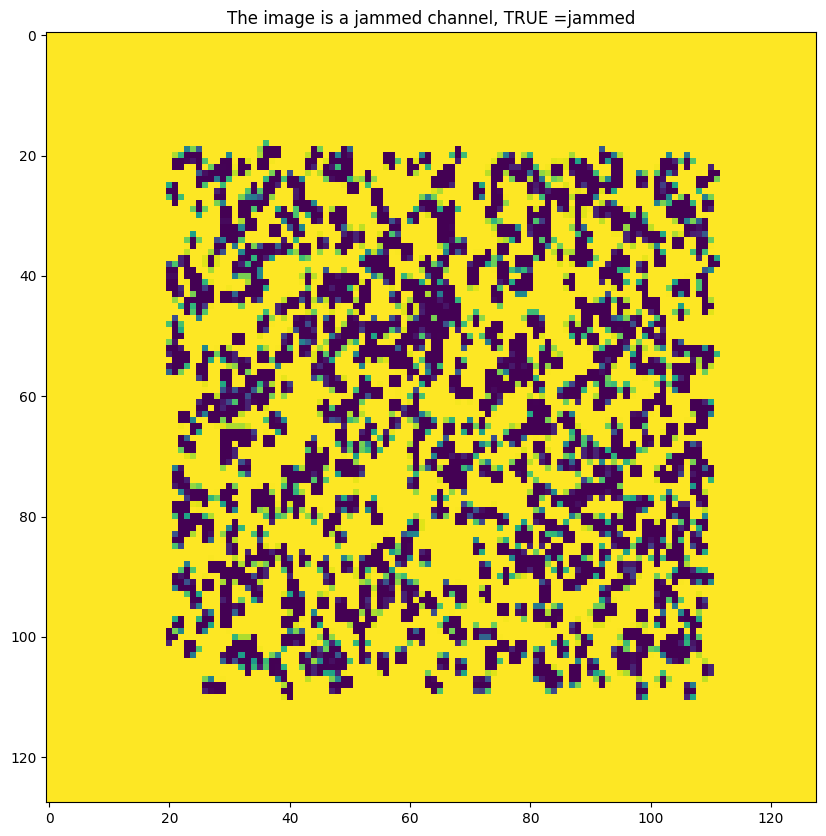

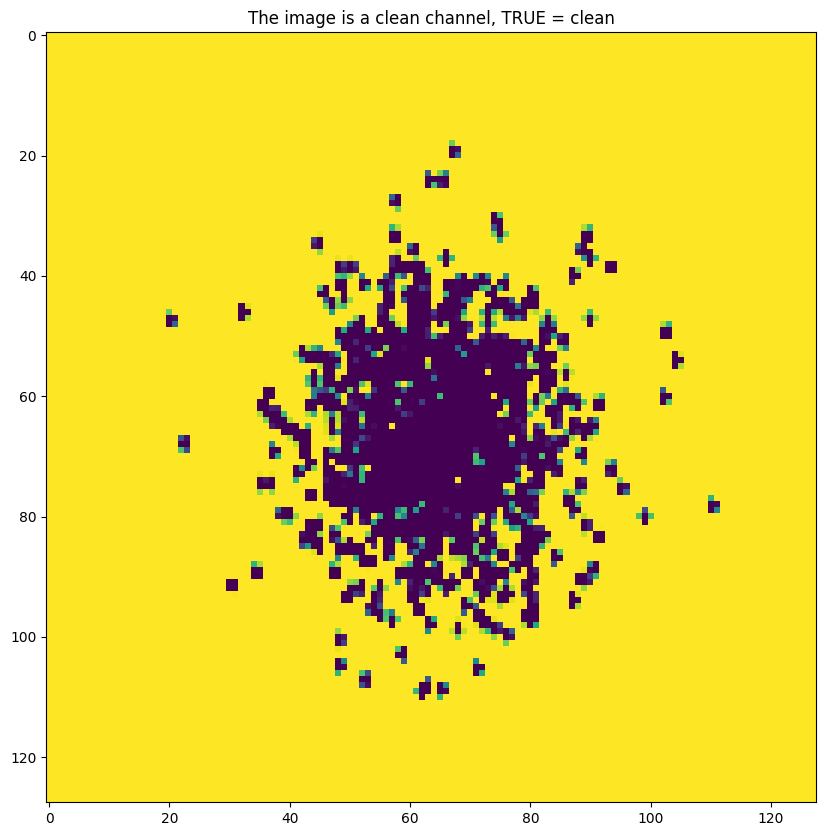

In [20]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [21]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [22]:
values_th=np.arange(min_range_th,max_range_th,0.0005) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

58


In [23]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


  0%|          | 2/800 [00:00<00:54, 14.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


  0%|          | 4/800 [00:00<00:50, 15.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0500


  1%|          | 6/800 [00:00<00:48, 16.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0268


  1%|          | 8/800 [00:00<00:47, 16.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0275


  1%|▏         | 10/800 [00:00<00:48, 16.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0302


  2%|▏         | 12/800 [00:00<00:50, 15.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


  2%|▏         | 14/800 [00:00<00:49, 15.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


  2%|▏         | 16/800 [00:00<00:48, 16.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0264


  2%|▏         | 18/800 [00:01<00:49, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0249


  2%|▎         | 20/800 [00:01<00:48, 15.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


  3%|▎         | 22/800 [00:01<00:48, 16.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


  3%|▎         | 24/800 [00:01<00:48, 15.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


  3%|▎         | 26/800 [00:01<00:49, 15.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


  4%|▎         | 28/800 [00:01<00:49, 15.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


  4%|▍         | 30/800 [00:01<00:51, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


  4%|▍         | 32/800 [00:02<00:49, 15.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0490


  4%|▍         | 34/800 [00:02<00:48, 15.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


  4%|▍         | 36/800 [00:02<00:49, 15.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0487


  5%|▍         | 38/800 [00:02<00:49, 15.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


  5%|▌         | 40/800 [00:02<00:50, 15.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


  5%|▌         | 42/800 [00:02<00:48, 15.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  6%|▌         | 44/800 [00:02<00:47, 16.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


  6%|▌         | 46/800 [00:02<00:47, 16.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


  6%|▌         | 48/800 [00:03<00:46, 16.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0291


  6%|▋         | 50/800 [00:03<00:44, 16.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0491


  6%|▋         | 52/800 [00:03<00:45, 16.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0269


  7%|▋         | 54/800 [00:03<00:45, 16.24it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0287


  7%|▋         | 56/800 [00:03<00:45, 16.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


  7%|▋         | 58/800 [00:03<00:46, 15.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


  8%|▊         | 60/800 [00:03<00:46, 15.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


  8%|▊         | 62/800 [00:03<00:46, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0497


  8%|▊         | 64/800 [00:04<00:45, 16.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


  8%|▊         | 66/800 [00:04<00:44, 16.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0494


  8%|▊         | 68/800 [00:04<00:43, 16.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


  9%|▉         | 70/800 [00:04<00:43, 16.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0268


  9%|▉         | 72/800 [00:04<00:44, 16.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


  9%|▉         | 74/800 [00:04<00:43, 16.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0270


 10%|▉         | 76/800 [00:04<00:44, 16.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 10%|▉         | 78/800 [00:04<00:45, 15.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 10%|█         | 80/800 [00:05<00:46, 15.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 10%|█         | 82/800 [00:05<00:45, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


 10%|█         | 84/800 [00:05<00:44, 16.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0255


 11%|█         | 86/800 [00:05<00:43, 16.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0242


 11%|█         | 88/800 [00:05<00:42, 16.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0332


 11%|█▏        | 90/800 [00:05<00:45, 15.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 12%|█▏        | 92/800 [00:05<00:44, 15.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0496


 12%|█▏        | 94/800 [00:05<00:45, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 12%|█▏        | 96/800 [00:06<00:45, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0490


 12%|█▏        | 98/800 [00:06<00:44, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 12%|█▎        | 100/800 [00:06<00:43, 16.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0270


 13%|█▎        | 102/800 [00:06<00:43, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0286


 13%|█▎        | 104/800 [00:06<00:43, 16.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 13%|█▎        | 106/800 [00:06<00:44, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 14%|█▎        | 108/800 [00:06<00:43, 15.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


 14%|█▍        | 110/800 [00:06<00:43, 15.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0311


 14%|█▍        | 112/800 [00:07<00:44, 15.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 14%|█▍        | 114/800 [00:07<00:44, 15.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 14%|█▍        | 116/800 [00:07<00:43, 15.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 15%|█▍        | 118/800 [00:07<00:43, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


 15%|█▌        | 120/800 [00:07<00:43, 15.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 15%|█▌        | 122/800 [00:07<00:43, 15.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 16%|█▌        | 124/800 [00:07<00:44, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0501


 16%|█▌        | 126/800 [00:07<00:44, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0496


 16%|█▌        | 128/800 [00:08<00:44, 15.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0296


 16%|█▋        | 130/800 [00:08<00:43, 15.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0497


 16%|█▋        | 132/800 [00:08<00:43, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0488


 17%|█▋        | 134/800 [00:08<00:41, 15.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 17%|█▋        | 136/800 [00:08<00:41, 15.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0223


 17%|█▋        | 138/800 [00:08<00:43, 15.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 18%|█▊        | 140/800 [00:08<00:42, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 18%|█▊        | 142/800 [00:08<00:42, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 18%|█▊        | 144/800 [00:09<00:41, 15.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0496


 18%|█▊        | 146/800 [00:09<00:40, 16.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0252


 18%|█▊        | 148/800 [00:09<00:41, 15.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0263


 19%|█▉        | 150/800 [00:09<00:44, 14.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0498


 19%|█▉        | 152/800 [00:09<00:49, 13.18it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0498


 19%|█▉        | 154/800 [00:09<00:52, 12.29it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0487


 20%|█▉        | 156/800 [00:10<00:55, 11.54it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0486


 20%|█▉        | 158/800 [00:10<00:55, 11.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0260


 20%|██        | 160/800 [00:10<00:54, 11.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0476


 20%|██        | 162/800 [00:10<00:54, 11.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0488


 20%|██        | 164/800 [00:10<00:54, 11.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0295


 21%|██        | 166/800 [00:10<00:52, 12.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0494


 21%|██        | 168/800 [00:11<00:52, 12.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0309


 21%|██▏       | 170/800 [00:11<00:52, 12.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 22%|██▏       | 172/800 [00:11<00:50, 12.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0275


 22%|██▏       | 174/800 [00:11<00:51, 12.14it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0496


 22%|██▏       | 176/800 [00:11<00:53, 11.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 22%|██▏       | 178/800 [00:11<00:50, 12.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0491


 22%|██▎       | 180/800 [00:12<00:47, 13.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 23%|██▎       | 182/800 [00:12<00:44, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0313


 23%|██▎       | 184/800 [00:12<00:43, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 23%|██▎       | 186/800 [00:12<00:43, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 24%|██▎       | 188/800 [00:12<00:41, 14.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 24%|██▍       | 190/800 [00:12<00:39, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


 24%|██▍       | 192/800 [00:12<00:38, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 24%|██▍       | 194/800 [00:12<00:37, 16.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0497


 24%|██▍       | 196/800 [00:13<00:38, 15.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 25%|██▍       | 198/800 [00:13<00:39, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 25%|██▌       | 200/800 [00:13<00:37, 15.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 25%|██▌       | 202/800 [00:13<00:37, 15.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0495


 26%|██▌       | 204/800 [00:13<00:37, 15.92it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0489


 26%|██▌       | 206/800 [00:13<00:37, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 26%|██▌       | 208/800 [00:13<00:36, 16.17it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0487


 26%|██▋       | 210/800 [00:13<00:37, 15.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0257


 26%|██▋       | 212/800 [00:14<00:38, 15.28it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0301


 27%|██▋       | 214/800 [00:14<00:37, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 27%|██▋       | 216/800 [00:14<00:38, 15.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0317


 27%|██▋       | 218/800 [00:14<00:36, 15.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 28%|██▊       | 220/800 [00:14<00:37, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 28%|██▊       | 222/800 [00:14<00:37, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 28%|██▊       | 224/800 [00:14<00:36, 15.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 28%|██▊       | 226/800 [00:14<00:35, 16.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 28%|██▊       | 228/800 [00:15<00:35, 15.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 29%|██▉       | 230/800 [00:15<00:37, 15.37it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0494


 29%|██▉       | 232/800 [00:15<00:35, 15.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 29%|██▉       | 234/800 [00:15<00:34, 16.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0477


 30%|██▉       | 236/800 [00:15<00:33, 16.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 30%|██▉       | 238/800 [00:15<00:33, 16.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0499


 30%|███       | 240/800 [00:15<00:35, 15.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0256


 30%|███       | 242/800 [00:15<00:35, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 30%|███       | 244/800 [00:16<00:36, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0498


 31%|███       | 246/800 [00:16<00:36, 15.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 31%|███       | 248/800 [00:16<00:36, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 31%|███▏      | 250/800 [00:16<00:34, 15.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 32%|███▏      | 252/800 [00:16<00:35, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 32%|███▏      | 254/800 [00:16<00:35, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0499


 32%|███▏      | 256/800 [00:16<00:34, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 32%|███▏      | 258/800 [00:16<00:35, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0268


 32%|███▎      | 260/800 [00:17<00:34, 15.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 33%|███▎      | 262/800 [00:17<00:34, 15.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 33%|███▎      | 264/800 [00:17<00:33, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 33%|███▎      | 266/800 [00:17<00:32, 16.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0498


 34%|███▎      | 268/800 [00:17<00:33, 15.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 34%|███▍      | 270/800 [00:17<00:34, 15.56it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0314


 34%|███▍      | 272/800 [00:17<00:32, 16.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 34%|███▍      | 274/800 [00:17<00:33, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 34%|███▍      | 276/800 [00:18<00:34, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 35%|███▍      | 278/800 [00:18<00:36, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 35%|███▌      | 280/800 [00:18<00:36, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 35%|███▌      | 282/800 [00:18<00:35, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 36%|███▌      | 284/800 [00:18<00:34, 14.87it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0480


 36%|███▌      | 286/800 [00:18<00:32, 15.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0275


 36%|███▌      | 288/800 [00:18<00:32, 15.93it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0276


 36%|███▋      | 290/800 [00:19<00:33, 15.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


 36%|███▋      | 292/800 [00:19<00:33, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 37%|███▋      | 294/800 [00:19<00:33, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 37%|███▋      | 296/800 [00:19<00:32, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0226


 37%|███▋      | 298/800 [00:19<00:32, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 38%|███▊      | 300/800 [00:19<00:32, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 38%|███▊      | 302/800 [00:19<00:32, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 38%|███▊      | 304/800 [00:19<00:31, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0269


 38%|███▊      | 306/800 [00:20<00:31, 15.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0266


 38%|███▊      | 308/800 [00:20<00:32, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 39%|███▉      | 310/800 [00:20<00:31, 15.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 39%|███▉      | 312/800 [00:20<00:30, 15.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 39%|███▉      | 314/800 [00:20<00:30, 15.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 40%|███▉      | 316/800 [00:20<00:31, 15.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 40%|███▉      | 318/800 [00:20<00:31, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 40%|████      | 320/800 [00:20<00:30, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 40%|████      | 322/800 [00:21<00:30, 15.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 40%|████      | 324/800 [00:21<00:30, 15.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 41%|████      | 326/800 [00:21<00:30, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 41%|████      | 328/800 [00:21<00:30, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 41%|████▏     | 330/800 [00:21<00:30, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 42%|████▏     | 332/800 [00:21<00:30, 15.33it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0491


 42%|████▏     | 334/800 [00:21<00:36, 12.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0285


 42%|████▏     | 336/800 [00:22<00:37, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0260


 42%|████▏     | 338/800 [00:22<00:38, 11.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 42%|████▎     | 340/800 [00:22<00:38, 11.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 43%|████▎     | 342/800 [00:22<00:38, 11.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 43%|████▎     | 344/800 [00:22<00:36, 12.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0487


 43%|████▎     | 346/800 [00:22<00:36, 12.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0308


 44%|████▎     | 348/800 [00:23<00:38, 11.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 44%|████▍     | 350/800 [00:23<00:38, 11.78it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0259


 44%|████▍     | 352/800 [00:23<00:39, 11.31it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0496


 44%|████▍     | 354/800 [00:23<00:38, 11.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0475


 44%|████▍     | 356/800 [00:23<00:38, 11.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0494


 45%|████▍     | 358/800 [00:24<00:38, 11.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0482


 45%|████▌     | 360/800 [00:24<00:38, 11.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


 45%|████▌     | 362/800 [00:24<00:37, 11.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 46%|████▌     | 364/800 [00:24<00:34, 12.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 46%|████▌     | 366/800 [00:24<00:32, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 46%|████▌     | 368/800 [00:24<00:31, 13.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 46%|████▋     | 370/800 [00:24<00:30, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 46%|████▋     | 372/800 [00:25<00:30, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 47%|████▋     | 374/800 [00:25<00:29, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 47%|████▋     | 376/800 [00:25<00:28, 14.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 47%|████▋     | 378/800 [00:25<00:27, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 48%|████▊     | 380/800 [00:25<00:27, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


 48%|████▊     | 382/800 [00:25<00:26, 15.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 48%|████▊     | 384/800 [00:25<00:27, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0496


 48%|████▊     | 386/800 [00:25<00:27, 14.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0297


 48%|████▊     | 388/800 [00:26<00:27, 14.94it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0489


 49%|████▉     | 390/800 [00:26<00:28, 14.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 49%|████▉     | 392/800 [00:26<00:26, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 49%|████▉     | 394/800 [00:26<00:27, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 50%|████▉     | 396/800 [00:26<00:26, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 50%|████▉     | 398/800 [00:26<00:26, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 50%|█████     | 400/800 [00:26<00:25, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 50%|█████     | 402/800 [00:27<00:25, 15.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 50%|█████     | 404/800 [00:27<00:25, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0221


 51%|█████     | 406/800 [00:27<00:25, 15.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


 51%|█████     | 408/800 [00:27<00:25, 15.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0280


 51%|█████▏    | 410/800 [00:27<00:25, 15.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 52%|█████▏    | 412/800 [00:27<00:26, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 52%|█████▏    | 414/800 [00:27<00:26, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 52%|█████▏    | 416/800 [00:27<00:25, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 52%|█████▏    | 418/800 [00:28<00:26, 14.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0495


 52%|█████▎    | 420/800 [00:28<00:25, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 53%|█████▎    | 422/800 [00:28<00:25, 14.83it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0481


 53%|█████▎    | 424/800 [00:28<00:24, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 53%|█████▎    | 426/800 [00:28<00:24, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 54%|█████▎    | 428/800 [00:28<00:23, 15.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 54%|█████▍    | 430/800 [00:28<00:24, 15.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0264


 54%|█████▍    | 432/800 [00:29<00:24, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0497


 54%|█████▍    | 434/800 [00:29<00:24, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 55%|█████▍    | 436/800 [00:29<00:23, 15.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 55%|█████▍    | 438/800 [00:29<00:23, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 55%|█████▌    | 440/800 [00:29<00:23, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0256


 55%|█████▌    | 442/800 [00:29<00:23, 15.39it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0488


 56%|█████▌    | 444/800 [00:29<00:22, 15.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 56%|█████▌    | 446/800 [00:29<00:23, 15.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0257


 56%|█████▌    | 448/800 [00:30<00:23, 15.29it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0289


 56%|█████▋    | 450/800 [00:30<00:22, 15.59it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0488


 56%|█████▋    | 452/800 [00:30<00:22, 15.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 57%|█████▋    | 454/800 [00:30<00:22, 15.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 57%|█████▋    | 456/800 [00:30<00:22, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 57%|█████▋    | 458/800 [00:30<00:22, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 57%|█████▊    | 460/800 [00:30<00:21, 15.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0227


 58%|█████▊    | 462/800 [00:30<00:21, 15.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0252


 58%|█████▊    | 464/800 [00:31<00:21, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 58%|█████▊    | 466/800 [00:31<00:21, 15.35it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0253


 58%|█████▊    | 468/800 [00:31<00:20, 15.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0493


 59%|█████▉    | 470/800 [00:31<00:21, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0258


 59%|█████▉    | 472/800 [00:31<00:20, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0254


 59%|█████▉    | 474/800 [00:31<00:20, 15.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0495


 60%|█████▉    | 476/800 [00:31<00:20, 15.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 60%|█████▉    | 478/800 [00:31<00:20, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 60%|██████    | 480/800 [00:32<00:20, 15.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0498


 60%|██████    | 482/800 [00:32<00:20, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 60%|██████    | 484/800 [00:32<00:20, 15.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0290


 61%|██████    | 486/800 [00:32<00:20, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0492


 61%|██████    | 488/800 [00:32<00:20, 14.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0263


 61%|██████▏   | 490/800 [00:32<00:21, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 62%|██████▏   | 492/800 [00:32<00:20, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 62%|██████▏   | 494/800 [00:33<00:19, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 62%|██████▏   | 496/800 [00:33<00:19, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


 62%|██████▏   | 498/800 [00:33<00:19, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 62%|██████▎   | 500/800 [00:33<00:36,  8.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 63%|██████▎   | 502/800 [00:33<00:31,  9.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0287


 63%|██████▎   | 504/800 [00:34<00:28, 10.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0259


 63%|██████▎   | 506/800 [00:34<00:25, 11.38it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0498


 64%|██████▎   | 508/800 [00:34<00:26, 10.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0298


 64%|██████▍   | 510/800 [00:34<00:27, 10.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0486


 64%|██████▍   | 512/800 [00:34<00:27, 10.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 64%|██████▍   | 514/800 [00:35<00:27, 10.53it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0481


 64%|██████▍   | 516/800 [00:35<00:27, 10.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0285


 65%|██████▍   | 518/800 [00:35<00:26, 10.64it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0281


 65%|██████▌   | 520/800 [00:35<00:26, 10.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0494


 65%|██████▌   | 522/800 [00:35<00:27, 10.30it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0494


 66%|██████▌   | 524/800 [00:35<00:27, 10.14it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0492


 66%|██████▌   | 526/800 [00:36<00:26, 10.18it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0291


 66%|██████▌   | 528/800 [00:36<00:25, 10.47it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0483


 66%|██████▋   | 530/800 [00:36<00:26, 10.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0496


 66%|██████▋   | 532/800 [00:36<00:25, 10.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0490


 67%|██████▋   | 534/800 [00:36<00:24, 10.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


 67%|██████▋   | 536/800 [00:37<00:23, 11.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0497


 67%|██████▋   | 538/800 [00:37<00:22, 11.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 68%|██████▊   | 540/800 [00:37<00:21, 12.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0305


 68%|██████▊   | 542/800 [00:37<00:20, 12.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0292


 68%|██████▊   | 544/800 [00:37<00:19, 12.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 68%|██████▊   | 546/800 [00:37<00:19, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 68%|██████▊   | 548/800 [00:37<00:18, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 69%|██████▉   | 550/800 [00:38<00:18, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0491


 69%|██████▉   | 552/800 [00:38<00:18, 13.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0496


 69%|██████▉   | 554/800 [00:38<00:18, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 70%|██████▉   | 556/800 [00:38<00:17, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 70%|██████▉   | 558/800 [00:38<00:17, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0491


 70%|███████   | 560/800 [00:38<00:17, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0488


 70%|███████   | 562/800 [00:38<00:17, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0256


 70%|███████   | 564/800 [00:39<00:17, 13.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0299


 71%|███████   | 566/800 [00:39<00:16, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


 71%|███████   | 568/800 [00:39<00:16, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 71%|███████▏  | 570/800 [00:39<00:15, 14.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0265


 72%|███████▏  | 572/800 [00:39<00:15, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 72%|███████▏  | 574/800 [00:39<00:15, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0297


 72%|███████▏  | 576/800 [00:39<00:15, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 72%|███████▏  | 578/800 [00:40<00:15, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 72%|███████▎  | 580/800 [00:40<00:15, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 73%|███████▎  | 582/800 [00:40<00:15, 14.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0276


 73%|███████▎  | 584/800 [00:40<00:15, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


 73%|███████▎  | 586/800 [00:40<00:15, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0323


 74%|███████▎  | 588/800 [00:40<00:15, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 74%|███████▍  | 590/800 [00:40<00:14, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0304


 74%|███████▍  | 592/800 [00:41<00:14, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 74%|███████▍  | 594/800 [00:41<00:14, 14.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 74%|███████▍  | 596/800 [00:41<00:14, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 75%|███████▍  | 598/800 [00:41<00:13, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 75%|███████▌  | 600/800 [00:41<00:13, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 75%|███████▌  | 602/800 [00:41<00:13, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 76%|███████▌  | 604/800 [00:41<00:13, 14.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 76%|███████▌  | 606/800 [00:42<00:13, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0250


 76%|███████▌  | 608/800 [00:42<00:13, 14.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0494


 76%|███████▋  | 610/800 [00:42<00:12, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 76%|███████▋  | 612/800 [00:42<00:12, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


 77%|███████▋  | 614/800 [00:42<00:12, 15.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


 77%|███████▋  | 616/800 [00:42<00:11, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0495


 77%|███████▋  | 618/800 [00:42<00:11, 15.30it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0487


 78%|███████▊  | 620/800 [00:42<00:11, 15.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0497


 78%|███████▊  | 622/800 [00:43<00:11, 15.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 78%|███████▊  | 624/800 [00:43<00:11, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0505


 78%|███████▊  | 626/800 [00:43<00:11, 15.11it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0307


 78%|███████▊  | 628/800 [00:43<00:11, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 79%|███████▉  | 630/800 [00:43<00:11, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0495


 79%|███████▉  | 632/800 [00:43<00:10, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 79%|███████▉  | 634/800 [00:43<00:11, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 80%|███████▉  | 636/800 [00:43<00:11, 14.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 80%|███████▉  | 638/800 [00:44<00:10, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 80%|████████  | 640/800 [00:44<00:10, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 80%|████████  | 642/800 [00:44<00:10, 14.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 80%|████████  | 644/800 [00:44<00:10, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0238


 81%|████████  | 646/800 [00:44<00:10, 15.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 81%|████████  | 648/800 [00:44<00:09, 15.30it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0492


 81%|████████▏ | 650/800 [00:44<00:09, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0498


 82%|████████▏ | 652/800 [00:45<00:09, 15.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0495


 82%|████████▏ | 654/800 [00:45<00:09, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 82%|████████▏ | 656/800 [00:45<00:09, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 82%|████████▏ | 658/800 [00:45<00:09, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 82%|████████▎ | 660/800 [00:45<00:09, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 83%|████████▎ | 662/800 [00:45<00:09, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 83%|████████▎ | 664/800 [00:45<00:09, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 83%|████████▎ | 666/800 [00:45<00:08, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 84%|████████▎ | 668/800 [00:46<00:08, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 84%|████████▍ | 670/800 [00:46<00:08, 15.03it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0497


 84%|████████▍ | 672/800 [00:46<00:08, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 84%|████████▍ | 674/800 [00:46<00:08, 15.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 84%|████████▍ | 676/800 [00:46<00:08, 15.39it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0309


 85%|████████▍ | 678/800 [00:46<00:08, 14.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0299


 85%|████████▌ | 680/800 [00:46<00:09, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0489


 85%|████████▌ | 682/800 [00:47<00:09, 13.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0254


 86%|████████▌ | 684/800 [00:47<00:09, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0260


 86%|████████▌ | 686/800 [00:47<00:09, 12.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0493


 86%|████████▌ | 688/800 [00:47<00:08, 12.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0495


 86%|████████▋ | 690/800 [00:47<00:09, 12.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0288


 86%|████████▋ | 692/800 [00:47<00:09, 11.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0498


 87%|████████▋ | 694/800 [00:48<00:08, 12.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0494


 87%|████████▋ | 696/800 [00:48<00:08, 12.10it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0492


 87%|████████▋ | 698/800 [00:48<00:08, 11.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0496


 88%|████████▊ | 700/800 [00:48<00:08, 11.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0488


 88%|████████▊ | 702/800 [00:48<00:08, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0303


 88%|████████▊ | 704/800 [00:49<00:08, 11.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 88%|████████▊ | 706/800 [00:49<00:08, 11.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0336


 88%|████████▊ | 708/800 [00:49<00:08, 11.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 89%|████████▉ | 710/800 [00:49<00:07, 11.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0246


 89%|████████▉ | 712/800 [00:49<00:07, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 89%|████████▉ | 714/800 [00:49<00:06, 12.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 90%|████████▉ | 716/800 [00:49<00:06, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 90%|████████▉ | 718/800 [00:50<00:06, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0485


 90%|█████████ | 720/800 [00:50<00:05, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 90%|█████████ | 722/800 [00:50<00:05, 14.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0226


 90%|█████████ | 724/800 [00:50<00:05, 14.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0492


 91%|█████████ | 726/800 [00:50<00:05, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 91%|█████████ | 728/800 [00:50<00:04, 14.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0266


 91%|█████████▏| 730/800 [00:50<00:05, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


 92%|█████████▏| 732/800 [00:51<00:04, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 92%|█████████▏| 734/800 [00:51<00:04, 14.03it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0282


 92%|█████████▏| 736/800 [00:51<00:04, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 92%|█████████▏| 738/800 [00:51<00:04, 14.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0268


 92%|█████████▎| 740/800 [00:51<00:04, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


 93%|█████████▎| 742/800 [00:51<00:03, 14.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0486


 93%|█████████▎| 744/800 [00:51<00:03, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 93%|█████████▎| 746/800 [00:52<00:03, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 94%|█████████▎| 748/800 [00:52<00:03, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 94%|█████████▍| 750/800 [00:52<00:03, 14.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0481


 94%|█████████▍| 752/800 [00:52<00:03, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 94%|█████████▍| 754/800 [00:52<00:03, 15.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 94%|█████████▍| 756/800 [00:52<00:02, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 95%|█████████▍| 758/800 [00:52<00:02, 14.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0487


 95%|█████████▌| 760/800 [00:52<00:02, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


 95%|█████████▌| 762/800 [00:53<00:02, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 96%|█████████▌| 764/800 [00:53<00:02, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 96%|█████████▌| 766/800 [00:53<00:02, 14.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 96%|█████████▌| 768/800 [00:53<00:02, 14.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0251


 96%|█████████▋| 770/800 [00:53<00:02, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0488


 96%|█████████▋| 772/800 [00:53<00:01, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 97%|█████████▋| 774/800 [00:53<00:01, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 97%|█████████▋| 776/800 [00:54<00:01, 14.74it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0305


 97%|█████████▋| 778/800 [00:54<00:01, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 98%|█████████▊| 780/800 [00:54<00:01, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0250


 98%|█████████▊| 782/800 [00:54<00:01, 14.46it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0502


 98%|█████████▊| 784/800 [00:54<00:01, 14.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0257


 98%|█████████▊| 786/800 [00:54<00:00, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 98%|█████████▊| 788/800 [00:54<00:00, 14.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0306


 99%|█████████▉| 790/800 [00:55<00:00, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 99%|█████████▉| 792/800 [00:55<00:00, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 99%|█████████▉| 794/800 [00:55<00:00, 14.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0265


100%|█████████▉| 796/800 [00:55<00:00, 14.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


100%|█████████▉| 798/800 [00:55<00:00, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


100%|██████████| 800/800 [00:55<00:00, 14.36it/s]

800


In [24]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [25]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [26]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.01875, 0.0975, 0.2675, 0.40875, 0.48375, 0.49875]
[0.5, 0.4975, 0.4925, 0.49125, 0.48375, 0.4775, 0.47, 0.44875, 0.41625, 0.3725, 0.33125, 0.31, 0.27125, 0.23125, 0.16625, 0.115, 0.07, 0.0425, 0.01875, 0.0125, 0.00625, 0.0025, 0.0025, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


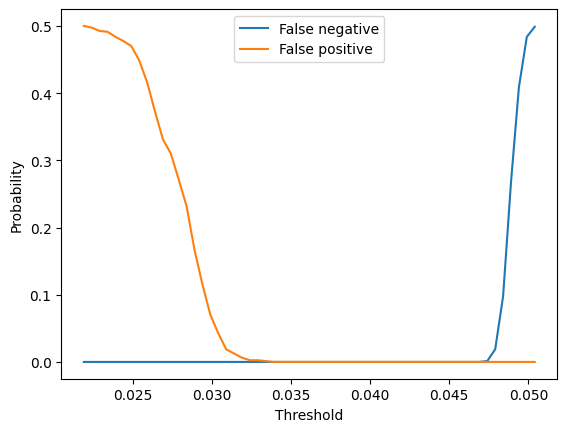

In [27]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [ ]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0229


  0%|          | 2/800 [00:00<00:57, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


  0%|          | 4/800 [00:00<00:50, 15.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0295


  1%|          | 6/800 [00:00<00:47, 16.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


  1%|          | 8/800 [00:00<00:47, 16.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0474


  1%|▏         | 10/800 [00:00<00:46, 17.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


  2%|▏         | 12/800 [00:00<00:46, 16.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0296


  2%|▏         | 14/800 [00:00<00:47, 16.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


  2%|▏         | 16/800 [00:00<00:47, 16.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


  2%|▏         | 18/800 [00:01<00:50, 15.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0278


  2%|▎         | 20/800 [00:01<00:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0485


  3%|▎         | 22/800 [00:01<00:48, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


  3%|▎         | 24/800 [00:01<00:48, 16.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


  3%|▎         | 26/800 [00:01<00:47, 16.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


  4%|▎         | 28/800 [00:01<00:47, 16.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0496


  4%|▍         | 30/800 [00:01<00:49, 15.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


  4%|▍         | 32/800 [00:02<00:49, 15.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


  4%|▍         | 34/800 [00:02<00:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


  4%|▍         | 36/800 [00:02<00:46, 16.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


  5%|▍         | 38/800 [00:02<00:47, 16.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  5%|▌         | 40/800 [00:02<00:46, 16.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0477


  5%|▌         | 42/800 [00:02<00:46, 16.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


  6%|▌         | 44/800 [00:02<00:47, 15.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


  6%|▌         | 46/800 [00:02<00:47, 15.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


  6%|▌         | 48/800 [00:02<00:46, 16.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


  6%|▋         | 50/800 [00:03<00:46, 16.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0478


  6%|▋         | 52/800 [00:03<00:46, 16.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0498


  7%|▋         | 54/800 [00:03<00:44, 16.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


  7%|▋         | 56/800 [00:03<00:45, 16.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


  7%|▋         | 58/800 [00:03<00:45, 16.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


  8%|▊         | 60/800 [00:03<00:46, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


  8%|▊         | 62/800 [00:03<00:47, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


  8%|▊         | 64/800 [00:03<00:46, 15.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0477


  8%|▊         | 66/800 [00:04<00:46, 15.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


  8%|▊         | 68/800 [00:04<00:44, 16.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


  9%|▉         | 70/800 [00:04<00:44, 16.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0231


  9%|▉         | 72/800 [00:04<00:44, 16.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


  9%|▉         | 74/800 [00:04<00:46, 15.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 10%|▉         | 76/800 [00:05<01:24,  8.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0290


 10%|▉         | 78/800 [00:05<01:14,  9.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 10%|█         | 80/800 [00:05<01:07, 10.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 10%|█         | 82/800 [00:05<01:01, 11.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 10%|█         | 84/800 [00:05<00:59, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0284


 11%|█         | 86/800 [00:05<00:58, 12.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 11%|█         | 88/800 [00:05<00:56, 12.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 11%|█▏        | 90/800 [00:06<00:55, 12.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0250


 12%|█▏        | 92/800 [00:06<00:55, 12.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 12%|█▏        | 94/800 [00:06<00:52, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0261


 12%|█▏        | 96/800 [00:06<00:51, 13.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0292


 12%|█▏        | 98/800 [00:06<00:50, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 12%|█▎        | 100/800 [00:06<00:51, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 13%|█▎        | 102/800 [00:06<00:49, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0273


 13%|█▎        | 104/800 [00:07<00:49, 13.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0315


 13%|█▎        | 106/800 [00:07<00:48, 14.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0478


 14%|█▎        | 108/800 [00:07<00:50, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 14%|█▍        | 110/800 [00:07<00:49, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 14%|█▍        | 112/800 [00:07<00:48, 14.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0484


 14%|█▍        | 114/800 [00:07<00:52, 13.18it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0493


 14%|█▍        | 116/800 [00:08<00:57, 11.90it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0493


 15%|█▍        | 118/800 [00:08<00:58, 11.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0489


 15%|█▌        | 120/800 [00:08<00:59, 11.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0476


 15%|█▌        | 122/800 [00:08<00:59, 11.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0489


 16%|█▌        | 124/800 [00:08<01:00, 11.10it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0488


 16%|█▌        | 126/800 [00:08<01:01, 10.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0288


 16%|█▌        | 128/800 [00:09<01:00, 11.14it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0302


 16%|█▋        | 130/800 [00:09<00:59, 11.19it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0492


 16%|█▋        | 132/800 [00:09<01:00, 11.10it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0488


 17%|█▋        | 134/800 [00:09<01:01, 10.79it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0489


 17%|█▋        | 136/800 [00:09<01:03, 10.49it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0262


 17%|█▋        | 138/800 [00:10<01:02, 10.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


 18%|█▊        | 140/800 [00:10<00:57, 11.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 18%|█▊        | 142/800 [00:10<00:55, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 18%|█▊        | 144/800 [00:10<00:52, 12.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 18%|█▊        | 146/800 [00:10<00:50, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 18%|█▊        | 148/800 [00:10<00:47, 13.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0484


 19%|█▉        | 150/800 [00:10<00:47, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 19%|█▉        | 152/800 [00:11<00:47, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0243


 19%|█▉        | 154/800 [00:11<00:45, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 20%|█▉        | 156/800 [00:11<00:43, 14.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 20%|█▉        | 158/800 [00:11<00:45, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 20%|██        | 160/800 [00:11<00:45, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 20%|██        | 162/800 [00:11<00:43, 14.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0481


 20%|██        | 164/800 [00:11<00:44, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 21%|██        | 166/800 [00:12<00:42, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0217


 21%|██        | 168/800 [00:12<00:43, 14.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0269


 21%|██▏       | 170/800 [00:12<00:43, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 22%|██▏       | 172/800 [00:12<00:42, 14.76it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0263


 22%|██▏       | 174/800 [00:12<00:41, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0303


 22%|██▏       | 176/800 [00:12<00:41, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 22%|██▏       | 178/800 [00:12<00:41, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 22%|██▎       | 180/800 [00:12<00:40, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 23%|██▎       | 182/800 [00:13<00:39, 15.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 23%|██▎       | 184/800 [00:13<00:41, 14.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0481


 23%|██▎       | 186/800 [00:13<00:41, 14.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


 24%|██▎       | 188/800 [00:13<00:39, 15.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 24%|██▍       | 190/800 [00:13<00:39, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 24%|██▍       | 192/800 [00:13<00:40, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 24%|██▍       | 194/800 [00:13<00:39, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0255


 24%|██▍       | 196/800 [00:14<00:39, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 25%|██▍       | 198/800 [00:14<00:38, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 25%|██▌       | 200/800 [00:14<00:38, 15.58it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0248


 25%|██▌       | 202/800 [00:14<00:38, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 26%|██▌       | 204/800 [00:14<00:36, 16.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0257


 26%|██▌       | 206/800 [00:14<00:36, 16.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 26%|██▌       | 208/800 [00:14<00:37, 15.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 26%|██▋       | 210/800 [00:14<00:37, 15.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 26%|██▋       | 212/800 [00:15<00:36, 15.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0500


 27%|██▋       | 214/800 [00:15<00:37, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 27%|██▋       | 216/800 [00:15<00:38, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 27%|██▋       | 218/800 [00:15<00:39, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0487


 28%|██▊       | 220/800 [00:15<00:38, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 28%|██▊       | 222/800 [00:15<00:37, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0263


 28%|██▊       | 224/800 [00:15<00:37, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0270


 28%|██▊       | 226/800 [00:15<00:37, 15.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0279


 28%|██▊       | 228/800 [00:16<00:39, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 29%|██▉       | 230/800 [00:16<00:38, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0247


 29%|██▉       | 232/800 [00:16<00:36, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 29%|██▉       | 234/800 [00:16<00:37, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0239


 30%|██▉       | 236/800 [00:16<00:36, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0302


 30%|██▉       | 238/800 [00:16<00:36, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 30%|███       | 240/800 [00:16<00:36, 15.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 30%|███       | 242/800 [00:17<00:35, 15.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 30%|███       | 244/800 [00:17<00:36, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 31%|███       | 246/800 [00:17<00:37, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 31%|███       | 248/800 [00:17<00:37, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


 31%|███▏      | 250/800 [00:17<00:37, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0297


 32%|███▏      | 252/800 [00:17<00:37, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0258


 32%|███▏      | 254/800 [00:17<00:36, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 32%|███▏      | 256/800 [00:17<00:36, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0492


 32%|███▏      | 258/800 [00:18<00:35, 15.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0488


 32%|███▎      | 260/800 [00:18<00:37, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 33%|███▎      | 262/800 [00:18<00:37, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 33%|███▎      | 264/800 [00:18<00:36, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0494


 33%|███▎      | 266/800 [00:18<00:36, 14.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0487


 34%|███▎      | 268/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 34%|███▍      | 270/800 [00:18<00:35, 15.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0260


 34%|███▍      | 272/800 [00:19<00:35, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 34%|███▍      | 274/800 [00:19<00:35, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 34%|███▍      | 276/800 [00:19<00:36, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 35%|███▍      | 278/800 [00:19<00:36, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0297


 35%|███▌      | 280/800 [00:19<00:35, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 35%|███▌      | 282/800 [00:19<00:34, 14.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0256


 36%|███▌      | 284/800 [00:19<00:35, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 36%|███▌      | 286/800 [00:20<00:35, 14.63it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0486


 36%|███▌      | 288/800 [00:20<00:41, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 36%|███▋      | 290/800 [00:20<00:42, 12.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0303


 36%|███▋      | 292/800 [00:20<00:44, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0495


 37%|███▋      | 294/800 [00:20<00:43, 11.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0261


 37%|███▋      | 296/800 [00:20<00:44, 11.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0310


 37%|███▋      | 298/800 [00:21<00:44, 11.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0249


 38%|███▊      | 300/800 [00:21<00:43, 11.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 38%|███▊      | 302/800 [00:21<00:42, 11.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0479


 38%|███▊      | 304/800 [00:21<00:44, 11.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0492


 38%|███▊      | 306/800 [00:21<00:44, 10.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 38%|███▊      | 308/800 [00:22<00:45, 10.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0483


 39%|███▉      | 310/800 [00:22<00:45, 10.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0487


 39%|███▉      | 312/800 [00:22<00:45, 10.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 39%|███▉      | 314/800 [00:22<00:41, 11.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


 40%|███▉      | 316/800 [00:22<00:38, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 40%|███▉      | 318/800 [00:22<00:36, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 40%|████      | 320/800 [00:22<00:35, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 40%|████      | 322/800 [00:23<00:34, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 40%|████      | 324/800 [00:23<00:33, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 41%|████      | 326/800 [00:23<00:32, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 41%|████      | 328/800 [00:23<00:31, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 41%|████▏     | 330/800 [00:23<00:31, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 42%|████▏     | 332/800 [00:23<00:31, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 42%|████▏     | 334/800 [00:23<00:30, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 42%|████▏     | 336/800 [00:24<00:30, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0476


 42%|████▏     | 338/800 [00:24<00:30, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 42%|████▎     | 340/800 [00:24<00:30, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 43%|████▎     | 342/800 [00:24<00:29, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0491


 43%|████▎     | 344/800 [00:24<00:30, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 43%|████▎     | 346/800 [00:24<00:31, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 44%|████▎     | 348/800 [00:24<00:30, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 44%|████▍     | 350/800 [00:24<00:30, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 44%|████▍     | 352/800 [00:25<00:29, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 44%|████▍     | 354/800 [00:25<00:29, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0260


 44%|████▍     | 356/800 [00:25<00:29, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 45%|████▍     | 358/800 [00:25<00:28, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 45%|████▌     | 360/800 [00:25<00:28, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 45%|████▌     | 362/800 [00:25<00:27, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 46%|████▌     | 364/800 [00:25<00:28, 15.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0249


 46%|████▌     | 366/800 [00:25<00:29, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 46%|████▌     | 368/800 [00:26<00:28, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 46%|████▋     | 370/800 [00:26<00:28, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 46%|████▋     | 372/800 [00:26<00:28, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 47%|████▋     | 374/800 [00:26<00:29, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 47%|████▋     | 376/800 [00:26<00:28, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0230


 47%|████▋     | 378/800 [00:26<00:27, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0259


 48%|████▊     | 380/800 [00:26<00:27, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 48%|████▊     | 382/800 [00:27<00:27, 15.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 48%|████▊     | 384/800 [00:27<00:27, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 48%|████▊     | 386/800 [00:27<00:28, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 48%|████▊     | 388/800 [00:27<00:27, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0253


 49%|████▉     | 390/800 [00:27<00:28, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 49%|████▉     | 392/800 [00:27<00:27, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 49%|████▉     | 394/800 [00:27<00:26, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0252


 50%|████▉     | 396/800 [00:27<00:26, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0475


 50%|████▉     | 398/800 [00:28<00:26, 15.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 50%|█████     | 400/800 [00:28<00:25, 15.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 50%|█████     | 402/800 [00:28<00:26, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 50%|█████     | 404/800 [00:28<00:26, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 51%|█████     | 406/800 [00:28<00:26, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 51%|█████     | 408/800 [00:28<00:26, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


 51%|█████▏    | 410/800 [00:28<00:25, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 52%|█████▏    | 412/800 [00:29<00:24, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 52%|█████▏    | 414/800 [00:29<00:25, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 52%|█████▏    | 416/800 [00:29<00:26, 14.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0272


 52%|█████▏    | 418/800 [00:29<00:26, 14.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 52%|█████▎    | 420/800 [00:29<00:25, 14.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 53%|█████▎    | 422/800 [00:29<00:25, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 53%|█████▎    | 424/800 [00:29<00:25, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0288


 53%|█████▎    | 426/800 [00:29<00:24, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 54%|█████▎    | 428/800 [00:30<00:24, 15.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0235


 54%|█████▍    | 430/800 [00:30<00:23, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 54%|█████▍    | 432/800 [00:30<00:23, 15.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 54%|█████▍    | 434/800 [00:30<00:24, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 55%|█████▍    | 436/800 [00:30<00:23, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 55%|█████▍    | 438/800 [00:30<00:23, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0267


 55%|█████▌    | 440/800 [00:30<00:23, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 55%|█████▌    | 442/800 [00:31<00:23, 15.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0476


 56%|█████▌    | 444/800 [00:31<00:23, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 56%|█████▌    | 446/800 [00:31<00:23, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 56%|█████▌    | 448/800 [00:31<00:22, 15.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 56%|█████▋    | 450/800 [00:31<00:22, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 56%|█████▋    | 452/800 [00:31<00:23, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 57%|█████▋    | 454/800 [00:31<00:23, 14.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0493


 57%|█████▋    | 456/800 [00:31<00:23, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 57%|█████▋    | 458/800 [00:32<00:22, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 57%|█████▊    | 460/800 [00:32<00:22, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0494


 58%|█████▊    | 462/800 [00:32<00:22, 14.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0270


 58%|█████▊    | 464/800 [00:32<00:24, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0489


 58%|█████▊    | 466/800 [00:32<00:25, 13.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0265


 58%|█████▊    | 468/800 [00:32<00:27, 12.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0270


 59%|█████▉    | 470/800 [00:33<00:27, 12.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0329


 59%|█████▉    | 472/800 [00:33<00:28, 11.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 59%|█████▉    | 474/800 [00:33<00:28, 11.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0274


 60%|█████▉    | 476/800 [00:33<00:28, 11.27it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0487


 60%|█████▉    | 478/800 [00:33<00:28, 11.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 60%|██████    | 480/800 [00:33<00:27, 11.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 60%|██████    | 482/800 [00:34<00:27, 11.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0491


 60%|██████    | 484/800 [00:34<00:26, 11.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0488


 61%|██████    | 486/800 [00:34<00:27, 11.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0493


 61%|██████    | 488/800 [00:34<00:27, 11.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0483


 61%|██████▏   | 490/800 [00:34<00:27, 11.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 62%|██████▏   | 492/800 [00:34<00:26, 11.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0266


 62%|██████▏   | 494/800 [00:35<00:24, 12.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 62%|██████▏   | 496/800 [00:35<00:23, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 62%|██████▏   | 498/800 [00:35<00:22, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 62%|██████▎   | 500/800 [00:35<00:22, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 63%|██████▎   | 502/800 [00:35<00:21, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 63%|██████▎   | 504/800 [00:35<00:20, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 63%|██████▎   | 506/800 [00:35<00:21, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 64%|██████▎   | 508/800 [00:36<00:20, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 64%|██████▍   | 510/800 [00:36<00:19, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 64%|██████▍   | 512/800 [00:36<00:19, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 64%|██████▍   | 514/800 [00:36<00:19, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 64%|██████▍   | 516/800 [00:36<00:18, 15.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0492


 65%|██████▍   | 518/800 [00:36<00:18, 15.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 65%|██████▌   | 520/800 [00:36<00:18, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 65%|██████▌   | 522/800 [00:37<00:18, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


 66%|██████▌   | 524/800 [00:37<00:17, 15.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 66%|██████▌   | 526/800 [00:37<00:17, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


 66%|██████▌   | 528/800 [00:37<00:18, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0267


 66%|██████▋   | 530/800 [00:37<00:18, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 66%|██████▋   | 532/800 [00:37<00:17, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 67%|██████▋   | 534/800 [00:37<00:17, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 67%|██████▋   | 536/800 [00:37<00:17, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0475


 67%|██████▋   | 538/800 [00:38<00:17, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 68%|██████▊   | 540/800 [00:38<00:17, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 68%|██████▊   | 542/800 [00:38<00:17, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 68%|██████▊   | 544/800 [00:38<00:16, 15.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 68%|██████▊   | 546/800 [00:38<00:17, 14.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0293


 68%|██████▊   | 548/800 [00:38<00:17, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 69%|██████▉   | 550/800 [00:38<00:17, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0248


 69%|██████▉   | 552/800 [00:39<00:17, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 69%|██████▉   | 554/800 [00:39<00:16, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 70%|██████▉   | 556/800 [00:39<00:16, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


 70%|██████▉   | 558/800 [00:39<00:16, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 70%|███████   | 560/800 [00:39<00:16, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 70%|███████   | 562/800 [00:39<00:16, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 70%|███████   | 564/800 [00:39<00:15, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 71%|███████   | 566/800 [00:39<00:15, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 71%|███████   | 568/800 [00:40<00:15, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0491


 71%|███████▏  | 570/800 [00:40<00:15, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 72%|███████▏  | 572/800 [00:40<00:15, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 72%|███████▏  | 574/800 [00:40<00:15, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 72%|███████▏  | 576/800 [00:40<00:15, 14.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0309


 72%|███████▏  | 578/800 [00:40<00:15, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 72%|███████▎  | 580/800 [00:40<00:15, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 73%|███████▎  | 582/800 [00:41<00:14, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0479


 73%|███████▎  | 584/800 [00:41<00:14, 14.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0299


 73%|███████▎  | 586/800 [00:41<00:14, 14.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0472


 74%|███████▎  | 588/800 [00:41<00:14, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 74%|███████▍  | 590/800 [00:41<00:14, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 74%|███████▍  | 592/800 [00:41<00:14, 14.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0308


 74%|███████▍  | 594/800 [00:41<00:14, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0489


 74%|███████▍  | 596/800 [00:42<00:13, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 75%|███████▍  | 598/800 [00:42<00:14, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 75%|███████▌  | 600/800 [00:42<00:13, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 75%|███████▌  | 602/800 [00:42<00:13, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 76%|███████▌  | 604/800 [00:42<00:13, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 76%|███████▌  | 606/800 [00:42<00:13, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 76%|███████▌  | 608/800 [00:42<00:13, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 76%|███████▋  | 610/800 [00:42<00:12, 14.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0478


 76%|███████▋  | 612/800 [00:43<00:12, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 77%|███████▋  | 614/800 [00:43<00:12, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 77%|███████▋  | 616/800 [00:43<00:12, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0296


 77%|███████▋  | 618/800 [00:43<00:12, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0494


 78%|███████▊  | 620/800 [00:43<00:12, 14.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0501


 78%|███████▊  | 622/800 [00:43<00:11, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 78%|███████▊  | 624/800 [00:43<00:11, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 78%|███████▊  | 626/800 [00:44<00:12, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 78%|███████▊  | 628/800 [00:44<00:11, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 79%|███████▉  | 630/800 [00:44<00:11, 14.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0296


 79%|███████▉  | 632/800 [00:44<00:11, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0484


 79%|███████▉  | 634/800 [00:44<00:11, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 80%|███████▉  | 636/800 [00:44<00:11, 14.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0494


 80%|███████▉  | 638/800 [00:44<00:11, 14.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0485


 80%|████████  | 640/800 [00:45<00:12, 12.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0321


 80%|████████  | 642/800 [00:45<00:12, 12.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0295


 80%|████████  | 644/800 [00:45<00:12, 12.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0494


 81%|████████  | 646/800 [00:45<00:12, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0473


 81%|████████  | 648/800 [00:45<00:12, 11.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0240


 81%|████████▏ | 650/800 [00:45<00:12, 11.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0282


 82%|████████▏ | 652/800 [00:46<00:13, 11.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0288


 82%|████████▏ | 654/800 [00:46<00:12, 11.44it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0480


 82%|████████▏ | 656/800 [00:46<00:13, 10.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0265


 82%|████████▏ | 658/800 [00:46<00:13, 10.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0483


 82%|████████▎ | 660/800 [00:46<00:12, 10.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0495


 83%|████████▎ | 662/800 [00:47<00:12, 11.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0485


 83%|████████▎ | 664/800 [00:47<00:12, 10.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0487


 83%|████████▎ | 666/800 [00:47<00:11, 11.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 84%|████████▎ | 668/800 [00:47<00:11, 11.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0490


 84%|████████▍ | 670/800 [00:47<00:10, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 84%|████████▍ | 672/800 [00:47<00:09, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0499


 84%|████████▍ | 674/800 [00:47<00:09, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 84%|████████▍ | 676/800 [00:48<00:09, 13.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0289


 85%|████████▍ | 678/800 [00:48<00:09, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 85%|████████▌ | 680/800 [00:48<00:08, 13.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0486


 85%|████████▌ | 682/800 [00:48<00:08, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 86%|████████▌ | 684/800 [00:48<00:08, 13.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0488


 86%|████████▌ | 686/800 [00:48<00:08, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 86%|████████▌ | 688/800 [00:48<00:07, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 86%|████████▋ | 690/800 [00:49<00:07, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 86%|████████▋ | 692/800 [00:49<00:07, 14.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 87%|████████▋ | 694/800 [00:49<00:07, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 87%|████████▋ | 696/800 [00:49<00:07, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 87%|████████▋ | 698/800 [00:49<00:06, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 88%|████████▊ | 700/800 [00:49<00:06, 15.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0481


 88%|████████▊ | 702/800 [00:49<00:06, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 88%|████████▊ | 704/800 [00:50<00:06, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 88%|████████▊ | 706/800 [00:50<00:06, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0236


 88%|████████▊ | 708/800 [00:50<00:06, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 89%|████████▉ | 710/800 [00:50<00:06, 14.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 89%|████████▉ | 712/800 [00:50<00:06, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 89%|████████▉ | 714/800 [00:50<00:05, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 90%|████████▉ | 716/800 [00:50<00:05, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 90%|████████▉ | 718/800 [00:50<00:05, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0482


 90%|█████████ | 720/800 [00:51<00:05, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 90%|█████████ | 722/800 [00:51<00:05, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 90%|█████████ | 724/800 [00:51<00:05, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 91%|█████████ | 726/800 [00:51<00:05, 14.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


 91%|█████████ | 728/800 [00:51<00:04, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0253


 91%|█████████▏| 730/800 [00:51<00:04, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0229


 92%|█████████▏| 732/800 [00:51<00:04, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 92%|█████████▏| 734/800 [00:52<00:04, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 92%|█████████▏| 736/800 [00:52<00:04, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 92%|█████████▏| 738/800 [00:52<00:04, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 92%|█████████▎| 740/800 [00:52<00:04, 14.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0484


 93%|█████████▎| 742/800 [00:52<00:04, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 93%|█████████▎| 744/800 [00:52<00:03, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 93%|█████████▎| 746/800 [00:52<00:03, 14.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0484


 94%|█████████▎| 748/800 [00:53<00:03, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 94%|█████████▍| 750/800 [00:53<00:03, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 94%|█████████▍| 752/800 [00:53<00:03, 14.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0488


 94%|█████████▍| 754/800 [00:53<00:03, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 94%|█████████▍| 756/800 [00:53<00:02, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0249


 95%|█████████▍| 758/800 [00:53<00:02, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 95%|█████████▌| 760/800 [00:53<00:02, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 95%|█████████▌| 762/800 [00:53<00:02, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0303


 96%|█████████▌| 764/800 [00:54<00:02, 14.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 96%|█████████▌| 766/800 [00:54<00:02, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 96%|█████████▌| 768/800 [00:54<00:02, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0486


 96%|█████████▋| 770/800 [00:54<00:02, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 96%|█████████▋| 772/800 [00:54<00:01, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 97%|█████████▋| 774/800 [00:54<00:01, 15.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0478


 97%|█████████▋| 776/800 [00:54<00:01, 13.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0293


 97%|█████████▋| 778/800 [00:55<00:01, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 98%|█████████▊| 780/800 [00:55<00:01, 13.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0492


 98%|█████████▊| 782/800 [00:55<00:01, 13.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0247


 98%|█████████▊| 784/800 [00:55<00:01, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 98%|█████████▊| 786/800 [00:55<00:00, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 98%|█████████▊| 788/800 [00:55<00:00, 14.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0257


 99%|█████████▉| 790/800 [00:55<00:00, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 99%|█████████▉| 792/800 [00:56<00:00, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 99%|█████████▉| 794/800 [00:56<00:00, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


100%|█████████▉| 796/800 [00:56<00:00, 14.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


100%|█████████▉| 798/800 [00:56<00:00, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


100%|██████████| 800/800 [00:56<00:00, 14.14it/s]


In [ ]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 96.25 %


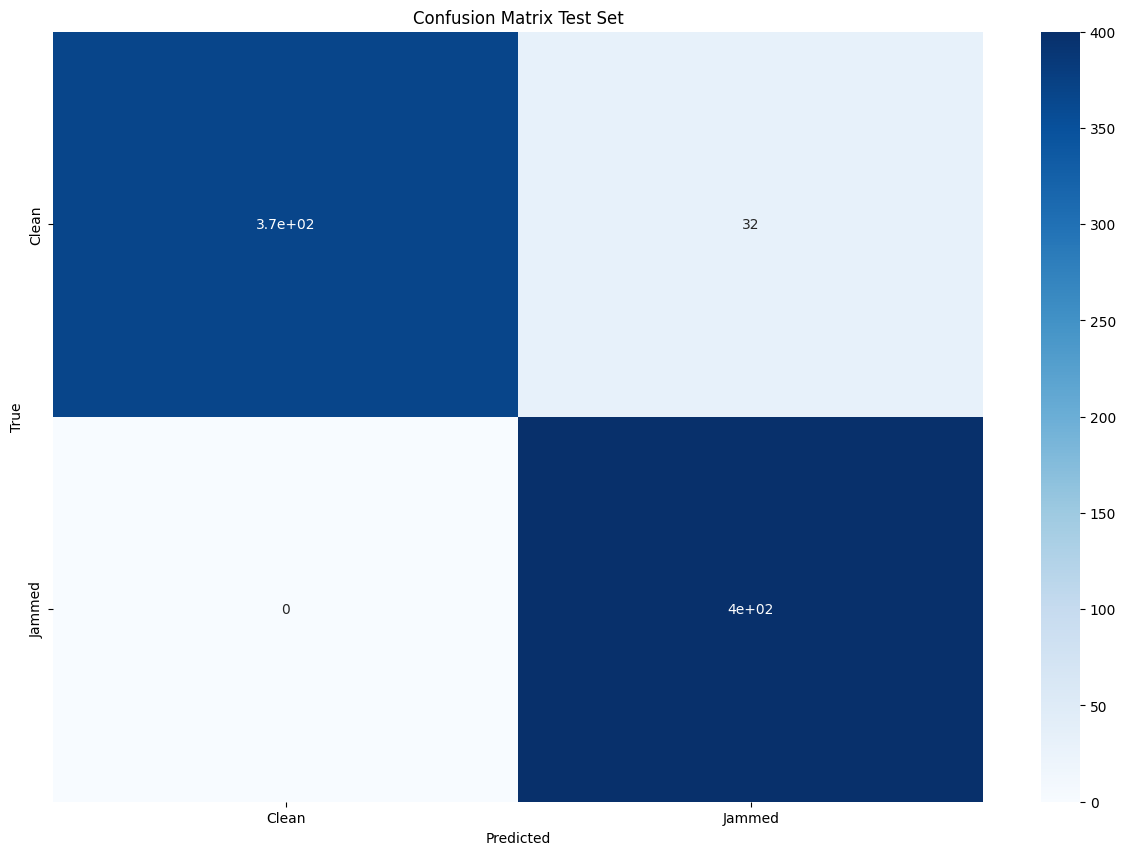

In [ ]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold